In [32]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import xarray as xr
import pandas as pd
import scipy
from datetime import datetime, timedelta
import time
import seaborn
import matplotlib.dates as mdates
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
import math
import netCDF4 as nc
import requests

# import chemO_funcs #import o2sat
from importlib import reload
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

import seaborn as sns

# Colors

In [219]:
princess_pink = ['#ffc2cd', '#ff93ac', '#ff6289', '#fc3468', '#ff084a']
ocean_blues = ['#c9fffe', '#9ffffe', '#82e9ff', '#36b6ff', '#0493ff']
purples = ['#efbbff', '#d896ff', '#be29ec', '#800080', '#660066']

# Set up Google Sheets API

In [2]:
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

scope = [
   'https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
#Name of our Service Account Key
google_key_file = 'servicecredentials-Copy1.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(google_key_file, scope)
gc = gspread.authorize(credentials)

# Get depth

In [72]:
depth = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLCM4_depth.nc')

In [79]:
depth.sel(x = 0, y = 0, method = 'nearest').deptho.values.tolist()

4856.4013671875

In [89]:
tmp_z = {'Lat': [], 'Lon': [], 'Z': []}
for i in depth.x:
    for j in depth.y:
        z = depth.sel(x = i, y = j, method = 'nearest').deptho.values.tolist()
        tmp_z['Lat'].append(round(j.values.tolist(),2))
        tmp_z['Lon'].append(round(i.values.tolist(),2))
        tmp_z['Z'].append(z)

In [92]:
tmp_Z = pd.DataFrame(tmp_z)
tmp_Z = tmp_Z.dropna()

In [94]:
tmp_Z.where(tmp_Z['Lat'] == 45.5).dropna()

,Lat,Lon,Z
2115,45.5,11.5,9.500000
2295,45.5,12.5,15.957868
2475,45.5,13.5,24.487892
5355,45.5,29.5,16.251192
5535,45.5,30.5,30.989813
...,...,...,...
63855,45.5,354.5,4578.197266
64035,45.5,355.5,4065.346191
64215,45.5,356.5,1654.648560
64395,45.5,357.5,200.440506


# GFDL + SOCAT

In [98]:
GFDL_SOCAT = pd.read_csv('/Users/akbaskind/Documents/Python Scripts/YoE/GFDLESM4_SOCAT_June25.csv')

In [99]:
GFDL_SOCAT

,Unnamed: 0.1,Unnamed: 0,Lat,Lon,GFDL Std Fugacity Detrended,SOCAT Std Fugacity Detrended,GFDL Std pH Detrended,SOCAT Std pH Detrended,GFDL Std Omega Detrended,SOCAT Std Omega Detrended,Z
0,0,0,-77.5,165.5,70.439747,32.139,0.111884,0.053945,0.449691,0.24297,573.775391
1,1,1,-77.5,166.5,72.004162,39.865,0.111023,0.069021,0.447630,0.30103,473.365448
2,2,2,-77.5,167.5,79.533071,60.509,0.113909,0.112500,0.516922,0.51244,594.203247
3,3,3,-77.5,173.5,67.359107,58.405,0.088186,0.075302,0.370955,0.26608,575.255432
4,4,4,-77.5,174.5,67.294759,69.767,0.088165,0.092958,0.371858,0.34124,470.206787
...,...,...,...,...,...,...,...,...,...,...,...
3831,3831,3831,79.5,4.5,36.087558,38.892,0.051899,0.067764,0.173121,0.33806,2612.616699
3832,3832,3832,79.5,5.5,37.034342,32.287,0.052617,0.054294,0.175103,0.25190,1960.235107
3833,3833,3833,79.5,6.5,37.652524,36.558,0.053251,0.054892,0.178797,0.27551,1398.370972
3834,3834,3834,79.5,7.5,37.625430,49.676,0.053228,0.069915,0.184231,0.35302,1015.313293


## Add depth

In [95]:
GFDL_SOCAT['Z'] = np.zeros(len(GFDL_SOCAT['Lat']))
for i in GFDL_SOCAT.index:
    y = GFDL_SOCAT['Lat'][i]
    x = GFDL_SOCAT['Lon'][i]
    ds_z = tmp_Z.where(tmp_Z['Lat'] == y).where(tmp_Z['Lon'] == x).dropna()
    z = ds_z['Z']
    GFDL_SOCAT['Z'][i] = z

In [97]:
GFDL_SOCAT.to_csv('/Users/akbaskind/Documents/Python Scripts/YoE/GFDLESM4_SOCAT_June25.csv')

## Divide up by shallow and deep

In [124]:
DEPTH = 1500

GFDL_SOCAT_shallow = GFDL_SOCAT_.where(GFDL_SOCAT_['Z'] < DEPTH).dropna()
GFDL_SOCAT_deep = GFDL_SOCAT_.where(GFDL_SOCAT_['Z'] > DEPTH).dropna()

# Reset indices
GFDL_SOCAT_shallow = GFDL_SOCAT_shallow.reset_index(drop=True)
GFDL_SOCAT_deep = GFDL_SOCAT_deep.reset_index(drop=True)

## Linear Regression: GFDL + SOCAT w/ Outliers

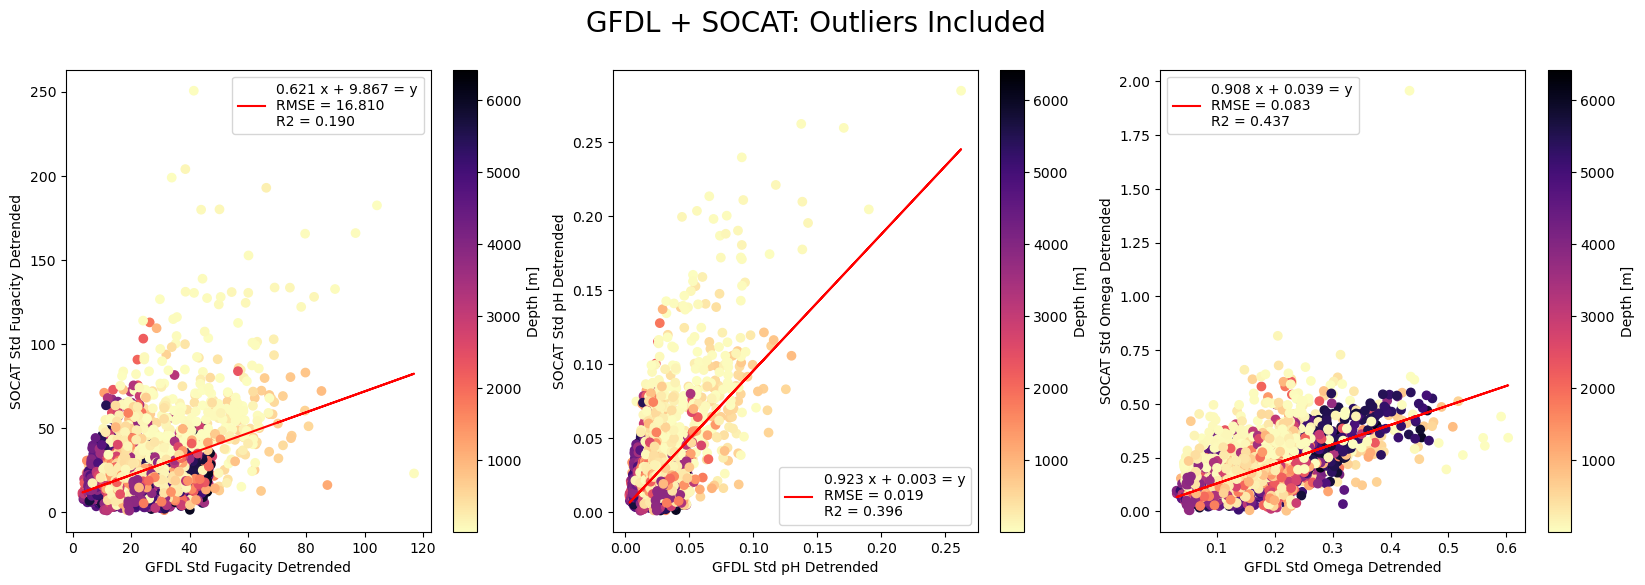

In [218]:
fig, axarr = plt.subplots(ncols = 3, figsize = [20, 6])
ax_idx = 0
var = ['Fugacity', 'pH', 'Omega']

for v in var:
    ax = axarr.flat[ax_idx]
    im = ax.scatter(GFDL_SOCAT['GFDL Std ' + v + ' Detrended'], GFDL_SOCAT['SOCAT Std ' + v + ' Detrended'], 
                    c = GFDL_SOCAT['Z'], cmap = 'magma_r')
    cbar = plt.colorbar(im, ax = ax)
    cbar.set_label('Depth [m]')
    ax.set_xlabel('GFDL Std ' + v + ' Detrended')
    ax.set_ylabel('SOCAT Std ' + v + ' Detrended')
    
    # Prep for linear regression
    GFDL_SOCAT_ = GFDL_SOCAT.dropna()
    x = GFDL_SOCAT_['GFDL Std ' + v + ' Detrended'].to_numpy() 
    y = GFDL_SOCAT_['SOCAT Std ' + v + ' Detrended'].to_numpy()
    n = np.size(x)
    
    # Cooks distance
    x2 = sm.add_constant(x)
    model = sm.OLS(y, x2).fit() 
    np.set_printoptions(suppress=True)
    influence = model.get_influence()
    cooks = influence.cooks_distance
    inf_sum = influence.summary_frame()
    
    x = x.reshape(-1,1)
    regression_model = LinearRegression()
  
    # Fit the data(train the model)
    regression_model.fit(x, y)
  
    # Predict
    y_predicted = regression_model.predict(x)
  
    # model evaluation
    mse=mean_squared_error(y,y_predicted)
  
    rmse = np.sqrt(mean_squared_error(y, y_predicted))
    r2 = r2_score(y, y_predicted)
    cff = "%.3f" % regression_model.coef_
    intcpt = "%.3f" % regression_model.intercept_
    RMSE = "%.3f" % rmse
    R2 = "%.3f" % r2
    
    lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
    ax.plot(x, y_predicted, color = 'red', label = lbl)
    ax.legend()
    
    ax_idx += 1

fig.suptitle('GFDL + SOCAT: Outliers Included', fontsize=20)
fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_SOCAT_STD_All_NoOutliers.png', bbox_inches='tight')

## Linear Regression: GFDL + SOCAT w/out Outliers

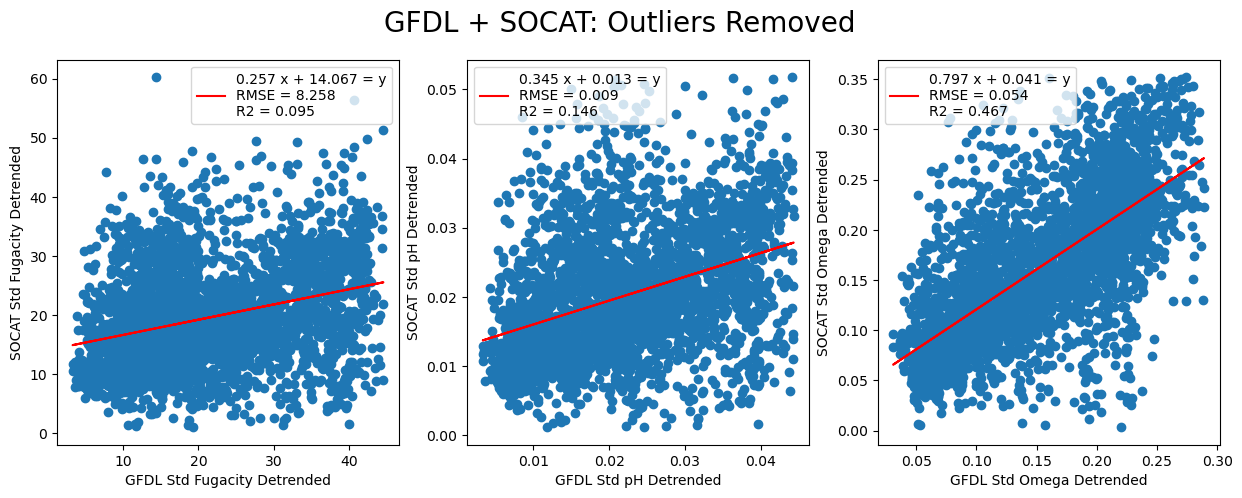

In [8]:
fig, axarr = plt.subplots(ncols = 3, figsize = [15,5])
ax_idx = 0
var = ['Fugacity', 'pH', 'Omega']

for v in var:
    ax = axarr.flat[ax_idx]
    
    # Plot data
    ax.scatter(test['GFDL Std ' + v + ' Detrended'], test['SOCAT Std ' + v + ' Detrended'])
    ax.set_xlabel('GFDL Std ' + v + ' Detrended')
    ax.set_ylabel('SOCAT Std ' + v + ' Detrended')
    
    # Prep for linear regression
    test = test.dropna()
    x = test['GFDL Std ' + v + ' Detrended'].to_numpy() 
    y = test['SOCAT Std ' + v + ' Detrended'].to_numpy()
    n = np.size(x)
    
    x = x.reshape(-1,1)
    regression_model = LinearRegression()
  
    # Fit the data(train the model)
    regression_model.fit(x, y)
  
    # Predict
    y_predicted = regression_model.predict(x)
  
    # model evaluation
    mse=mean_squared_error(y,y_predicted)
  
    rmse = np.sqrt(mean_squared_error(y, y_predicted))
    r2 = r2_score(y, y_predicted)
    cff = "%.3f" % regression_model.coef_
    intcpt = "%.3f" % regression_model.intercept_
    RMSE = "%.3f" % rmse
    R2 = "%.3f" % r2
    
    lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
    ax.plot(x, y_predicted, color = 'red', label = lbl)
    ax.legend()
    
    ax_idx += 1

fig.suptitle('GFDL + SOCAT: Outliers Removed', fontsize=20)
# fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_SOCAT_STD_All_NoOutliers.png', bbox_inches='tight')

# GFDL SOCAT fCO2 

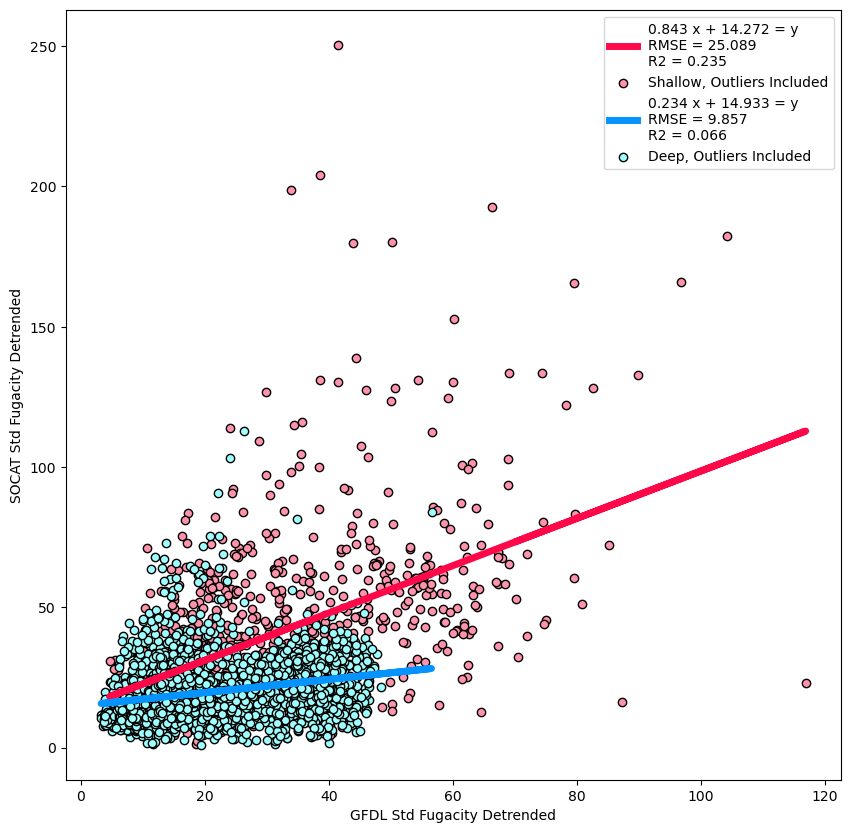

In [198]:
v = 'Fugacity'

fig, ax = plt.subplots(figsize = [10,10])

# SHALLOW ----------------------------------------------------------------------------------------------------
x_shallow = GFDL_SOCAT_shallow['GFDL Std ' + v + ' Detrended'].to_numpy() 
y_shallow = GFDL_SOCAT_shallow['SOCAT Std ' + v + ' Detrended'].to_numpy()

# Cook's distance as a function of GFDL fCO2
x2_shallow = sm.add_constant(x_shallow)
model_fCO2_GFDL_shallow = sm.OLS(y_shallow, x2_shallow).fit()
influence_fCO2_GFDL_shallow = model_fCO2_GFDL_shallow.get_influence()
inf_sum_fCO2_GFDL_shallow = influence_fCO2_GFDL_shallow.summary_frame()

# Cook's distance as a function of SOCAT fCO2
y2_shallow = sm.add_constant(y_shallow)
model_fCO2_SOCAT_shallow = sm.OLS(x_shallow, y2_shallow).fit() 
np.set_printoptions(suppress=True)
influence_fCO2_SOCAT_shallow = model_fCO2_SOCAT_shallow.get_influence()
inf_sum_fCO2_SOCAT_shallow = influence_fCO2_SOCAT_shallow.summary_frame()

x_shallow = x_shallow.reshape(-1,1)
regression_model_shallow = LinearRegression()
  
# Fit the data(train the model)
regression_model_shallow.fit(x_shallow, y_shallow)
  
# Predict
y_predicted_shallow = regression_model_shallow.predict(x_shallow)
  
# model evaluation
mse=mean_squared_error(y_shallow,y_predicted_shallow)
  
rmse_shallow = np.sqrt(mean_squared_error(y_shallow, y_predicted_shallow))
r2_shallow = r2_score(y_shallow, y_predicted_shallow)
cff_shallow = "%.3f" % regression_model_shallow.coef_
intcpt_shallow = "%.3f" % regression_model_shallow.intercept_
RMSE_shallow = "%.3f" % rmse_shallow
R2_shallow = "%.3f" % r2_shallow
    
lbl_shallow = cff_shallow + ' x + ' + intcpt_shallow + ' = y\nRMSE = ' + RMSE_shallow + '\nR2 = ' + R2_shallow
ax.plot(x_shallow, y_predicted_shallow, color = princess_pink[4], lw = 5, label = lbl_shallow)
ax.scatter(GFDL_SOCAT_shallow['GFDL Std ' + v + ' Detrended'], GFDL_SOCAT_shallow['SOCAT Std ' + v + ' Detrended'],
           facecolors = princess_pink[1], edgecolors = 'k', label = 'Shallow, Outliers Included')
# SHALLOW ----------------------------------------------------------------------------------------------------

# DEEP -------------------------------------------------------------------------------------------------------
x_deep = GFDL_SOCAT_deep['GFDL Std ' + v + ' Detrended'].to_numpy() 
y_deep = GFDL_SOCAT_deep['SOCAT Std ' + v + ' Detrended'].to_numpy()

# Cook's distance as a function of GFDL fCO2
x2_deep = sm.add_constant(x_deep)
model_fCO2_GFDL_deep = sm.OLS(y_deep, x2_deep).fit()
influence_fCO2_GFDL_deep = model_fCO2_GFDL_deep.get_influence()
inf_sum_fCO2_GFDL_deep = influence_fCO2_GFDL_deep.summary_frame()

# Cook's distance as a function of SOCAT fCO2
y2_deep = sm.add_constant(y_deep)
model_fCO2_SOCAT_deep = sm.OLS(x_deep, y2_deep).fit() 
influence_fCO2_SOCAT_deep = model_fCO2_SOCAT_deep.get_influence()
inf_sum_fCO2_SOCAT_deep = influence_fCO2_SOCAT_deep.summary_frame()

x_deep = x_deep.reshape(-1,1)
regression_model_deep = LinearRegression()
  
# Fit the data(train the model)
regression_model_deep.fit(x_deep, y_deep)
  
# Predict
y_predicted_deep = regression_model_deep.predict(x_deep)
  
# model evaluation
mse=mean_squared_error(y_deep,y_predicted_deep)
  
rmse_deep = np.sqrt(mean_squared_error(y_deep, y_predicted_deep))
r2_deep = r2_score(y_deep, y_predicted_deep)
cff_deep = "%.3f" % regression_model_deep.coef_
intcpt_deep = "%.3f" % regression_model_deep.intercept_
RMSE_deep = "%.3f" % rmse_deep
R2_deep = "%.3f" % r2_deep
    
lbl_deep = cff_deep + ' x + ' + intcpt_deep + ' = y\nRMSE = ' + RMSE_deep + '\nR2 = ' + R2_deep
ax.plot(x_deep, y_predicted_deep, color = ocean_blues[4], lw= 5, label = lbl_deep)
ax.scatter(GFDL_SOCAT_deep['GFDL Std ' + v + ' Detrended'], GFDL_SOCAT_deep['SOCAT Std ' + v + ' Detrended'],
           facecolors = ocean_blues[1], edgecolors = 'k', label = 'Deep, Outliers Included')
# DEEP -------------------------------------------------------------------------------------------------------

ax.set_xlabel('GFDL Std ' + v + ' Detrended')
ax.set_ylabel('SOCAT Std ' + v + ' Detrended')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_SOCAT_STD_fCO2_Outliers.png', bbox_inches='tight')

## Filter out outliers based on Cook's distance

Exclude points where Cook's distance is greater than 3x the mean Cook's distance

In [201]:
# SHALLOW
# FUGACITY

fco2_gfdl_socat_shallow = {'Lat': [], 'Lon': [], 'GFDL fCO2': [], 'SOCAT fCO2': [], 'Cooks GFDL': [], 'Cooks SOCAT': []}

for i in GFDL_SOCAT_shallow.index:
    fco2_gfdl_socat_shallow['Lat'].append(GFDL_SOCAT_shallow['Lat'][i])
    fco2_gfdl_socat_shallow['Lon'].append(GFDL_SOCAT_shallow['Lon'][i])
    fco2_gfdl_socat_shallow['GFDL fCO2'].append(GFDL_SOCAT_shallow['GFDL Std Fugacity Detrended'][i])
    fco2_gfdl_socat_shallow['SOCAT fCO2'].append(GFDL_SOCAT_shallow['SOCAT Std Fugacity Detrended'][i])
    fco2_gfdl_socat_shallow['Cooks GFDL'].append(inf_sum_fCO2_GFDL_shallow['cooks_d'][i])
    fco2_gfdl_socat_shallow['Cooks SOCAT'].append(inf_sum_fCO2_SOCAT_shallow['cooks_d'][i])
    
fco2_gfdl_socat_shallow = pd.DataFrame(fco2_gfdl_socat_shallow)
# Take out GFDL-based outliers
fco2_gfdl_socat_shallow = fco2_gfdl_socat_shallow.where(fco2_gfdl_socat_shallow['Cooks GFDL'] <=
                                                        3*fco2_gfdl_socat_shallow['Cooks GFDL'].mean()).dropna()
# Take out SOCAT-based outliers
fco2_gfdl_socat_shallow = fco2_gfdl_socat_shallow.where(fco2_gfdl_socat_shallow['Cooks SOCAT'] <=
                                                        3*fco2_gfdl_socat_shallow['Cooks SOCAT'].mean()).dropna()

In [202]:
# DEEP
# FUGACITY

fco2_gfdl_socat_deep = {'Lat': [], 'Lon': [], 'GFDL fCO2': [], 'SOCAT fCO2': [], 'Cooks GFDL': [], 'Cooks SOCAT': []}

for i in GFDL_SOCAT_deep.index:
    fco2_gfdl_socat_deep['Lat'].append(GFDL_SOCAT_deep['Lat'][i])
    fco2_gfdl_socat_deep['Lon'].append(GFDL_SOCAT_deep['Lon'][i])
    fco2_gfdl_socat_deep['GFDL fCO2'].append(GFDL_SOCAT_deep['GFDL Std Fugacity Detrended'][i])
    fco2_gfdl_socat_deep['SOCAT fCO2'].append(GFDL_SOCAT_deep['SOCAT Std Fugacity Detrended'][i])
    fco2_gfdl_socat_deep['Cooks GFDL'].append(inf_sum_fCO2_GFDL_deep['cooks_d'][i])
    fco2_gfdl_socat_deep['Cooks SOCAT'].append(inf_sum_fCO2_SOCAT_deep['cooks_d'][i])
    
fco2_gfdl_socat_deep = pd.DataFrame(fco2_gfdl_socat_deep)
# Take out GFDL-based outliers
fco2_gfdl_socat_deep = fco2_gfdl_socat_deep.where(fco2_gfdl_socat_deep['Cooks GFDL'] <=
                                                  3*fco2_gfdl_socat_deep['Cooks GFDL'].mean()).dropna()
# Take out SOCAT-based outliers
fco2_gfdl_socat_deep = fco2_gfdl_socat_deep.where(fco2_gfdl_socat_deep['Cooks SOCAT'] <=
                                                  3*fco2_gfdl_socat_deep['Cooks SOCAT'].mean()).dropna()

## GFDL SOCAT fCO2 Outiers removed

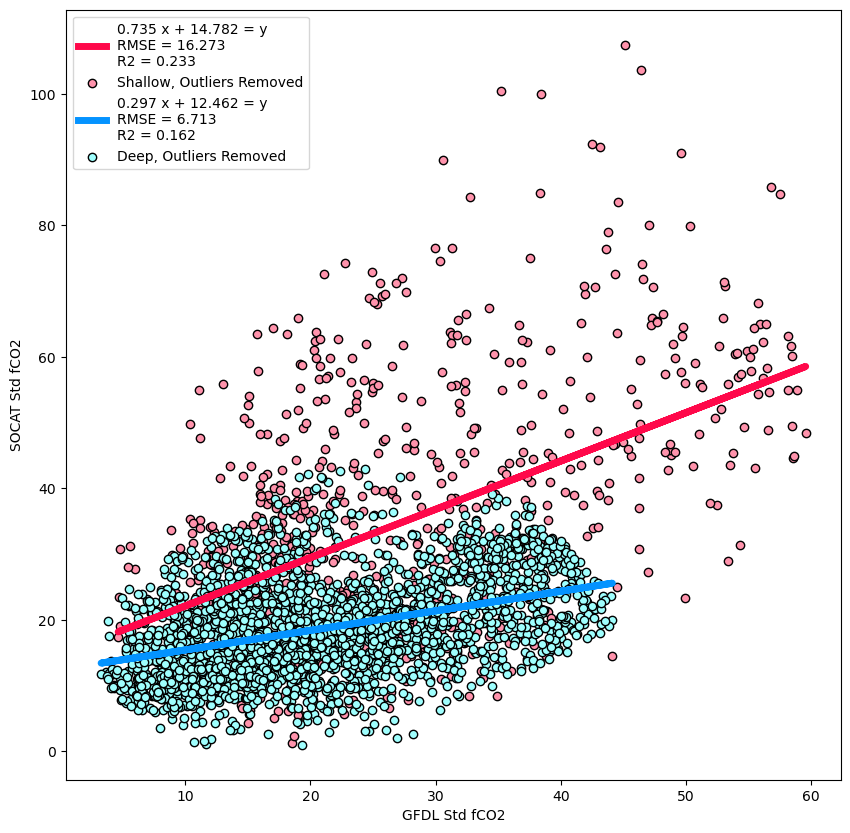

In [203]:
fig, ax = plt.subplots(figsize = [10,10])

# SHALLOW ----------------------------------------------------------------------------------------------------
x_shallow = fco2_gfdl_socat_shallow['GFDL fCO2'].to_numpy() 
y_shallow = fco2_gfdl_socat_shallow['SOCAT fCO2'].to_numpy()

x_shallow = x_shallow.reshape(-1,1)
regression_model_shallow = LinearRegression()
  
# Fit the data(train the model)
regression_model_shallow.fit(x_shallow, y_shallow)
  
# Predict
y_predicted_shallow = regression_model_shallow.predict(x_shallow)
  
# model evaluation
mse=mean_squared_error(y_shallow,y_predicted_shallow)
  
rmse_shallow = np.sqrt(mean_squared_error(y_shallow, y_predicted_shallow))
r2_shallow = r2_score(y_shallow, y_predicted_shallow)
cff_shallow = "%.3f" % regression_model_shallow.coef_
intcpt_shallow = "%.3f" % regression_model_shallow.intercept_
RMSE_shallow = "%.3f" % rmse_shallow
R2_shallow = "%.3f" % r2_shallow
    
lbl_shallow = cff_shallow + ' x + ' + intcpt_shallow + ' = y\nRMSE = ' + RMSE_shallow + '\nR2 = ' + R2_shallow
ax.plot(x_shallow, y_predicted_shallow, color = princess_pink[4], lw = 5, label = lbl_shallow)
ax.scatter(fco2_gfdl_socat_shallow['GFDL fCO2'], fco2_gfdl_socat_shallow['SOCAT fCO2'],
           facecolors = princess_pink[1], edgecolors = 'k', label = 'Shallow, Outliers Removed')
# SHALLOW ----------------------------------------------------------------------------------------------------

# DEEP -------------------------------------------------------------------------------------------------------
x_deep = fco2_gfdl_socat_deep['GFDL fCO2'].to_numpy() 
y_deep = fco2_gfdl_socat_deep['SOCAT fCO2'].to_numpy()

x_deep = x_deep.reshape(-1,1)
regression_model_deep = LinearRegression()
  
# Fit the data(train the model)
regression_model_deep.fit(x_deep, y_deep)
  
# Predict
y_predicted_deep = regression_model_deep.predict(x_deep)
  
# model evaluation
mse=mean_squared_error(y_deep,y_predicted_deep)
  
rmse_deep = np.sqrt(mean_squared_error(y_deep, y_predicted_deep))
r2_deep = r2_score(y_deep, y_predicted_deep)
cff_deep = "%.3f" % regression_model_deep.coef_
intcpt_deep = "%.3f" % regression_model_deep.intercept_
RMSE_deep = "%.3f" % rmse_deep
R2_deep = "%.3f" % r2_deep
    
lbl_deep = cff_deep + ' x + ' + intcpt_deep + ' = y\nRMSE = ' + RMSE_deep + '\nR2 = ' + R2_deep
ax.plot(x_deep, y_predicted_deep, color = ocean_blues[4], lw = 5, label = lbl_deep)
ax.scatter(fco2_gfdl_socat_deep['GFDL fCO2'], fco2_gfdl_socat_deep['SOCAT fCO2'],
           facecolors = ocean_blues[1], edgecolors = 'k', label = 'Deep, Outliers Removed')
# DEEP -------------------------------------------------------------------------------------------------------

ax.set_xlabel('GFDL Std fCO2')
ax.set_ylabel('SOCAT Std fCO2')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_SOCAT_STD_fCO2_NoOutliers.png', bbox_inches='tight')

# GFDL SOCAT pH

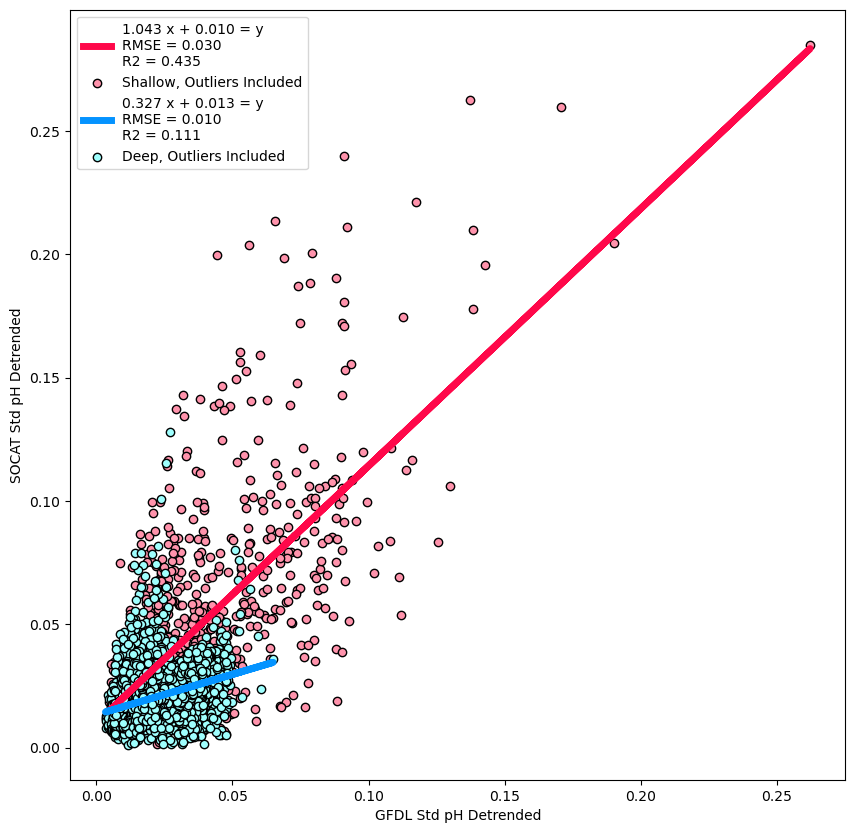

In [204]:
v = 'pH'

fig, ax = plt.subplots(figsize = [10,10])

# SHALLOW ----------------------------------------------------------------------------------------------------
x_shallow = GFDL_SOCAT_shallow['GFDL Std ' + v + ' Detrended'].to_numpy() 
y_shallow = GFDL_SOCAT_shallow['SOCAT Std ' + v + ' Detrended'].to_numpy()

# Cook's distance as a function of GFDL fCO2
x2_shallow = sm.add_constant(x_shallow)
model_ph_GFDL_shallow = sm.OLS(y_shallow, x2_shallow).fit()
influence_ph_GFDL_shallow = model_ph_GFDL_shallow.get_influence()
inf_sum_ph_GFDL_shallow = influence_ph_GFDL_shallow.summary_frame()

# Cook's distance as a function of SOCAT fCO2
y2_shallow = sm.add_constant(y_shallow)
model_ph_SOCAT_shallow = sm.OLS(x_shallow, y2_shallow).fit() 
np.set_printoptions(suppress=True)
influence_ph_SOCAT_shallow = model_ph_SOCAT_shallow.get_influence()
inf_sum_ph_SOCAT_shallow = influence_ph_SOCAT_shallow.summary_frame()

x_shallow = x_shallow.reshape(-1,1)
regression_model_shallow = LinearRegression()
  
# Fit the data(train the model)
regression_model_shallow.fit(x_shallow, y_shallow)
  
# Predict
y_predicted_shallow = regression_model_shallow.predict(x_shallow)
  
# model evaluation
mse=mean_squared_error(y_shallow,y_predicted_shallow)
  
rmse_shallow = np.sqrt(mean_squared_error(y_shallow, y_predicted_shallow))
r2_shallow = r2_score(y_shallow, y_predicted_shallow)
cff_shallow = "%.3f" % regression_model_shallow.coef_
intcpt_shallow = "%.3f" % regression_model_shallow.intercept_
RMSE_shallow = "%.3f" % rmse_shallow
R2_shallow = "%.3f" % r2_shallow
    
lbl_shallow = cff_shallow + ' x + ' + intcpt_shallow + ' = y\nRMSE = ' + RMSE_shallow + '\nR2 = ' + R2_shallow
ax.plot(x_shallow, y_predicted_shallow, color = princess_pink[4], lw = 5, label = lbl_shallow)
ax.scatter(GFDL_SOCAT_shallow['GFDL Std ' + v + ' Detrended'], GFDL_SOCAT_shallow['SOCAT Std ' + v + ' Detrended'],
           facecolors = princess_pink[1], edgecolors = 'k', label = 'Shallow, Outliers Included')
# SHALLOW ----------------------------------------------------------------------------------------------------

# DEEP -------------------------------------------------------------------------------------------------------
x_deep = GFDL_SOCAT_deep['GFDL Std ' + v + ' Detrended'].to_numpy() 
y_deep = GFDL_SOCAT_deep['SOCAT Std ' + v + ' Detrended'].to_numpy()

# Cook's distance as a function of GFDL fCO2
x2_deep = sm.add_constant(x_deep)
model_ph_GFDL_deep = sm.OLS(y_deep, x2_deep).fit()
influence_ph_GFDL_deep = model_ph_GFDL_deep.get_influence()
inf_sum_ph_GFDL_deep = influence_ph_GFDL_deep.summary_frame()

# Cook's distance as a function of SOCAT fCO2
y2_deep = sm.add_constant(y_deep)
model_ph_SOCAT_deep = sm.OLS(x_deep, y2_deep).fit() 
influence_ph_SOCAT_deep = model_ph_SOCAT_deep.get_influence()
inf_sum_ph_SOCAT_deep = influence_ph_SOCAT_deep.summary_frame()

x_deep = x_deep.reshape(-1,1)
regression_model_deep = LinearRegression()
  
# Fit the data(train the model)
regression_model_deep.fit(x_deep, y_deep)
  
# Predict
y_predicted_deep = regression_model_deep.predict(x_deep)
  
# model evaluation
mse=mean_squared_error(y_deep,y_predicted_deep)
  
rmse_deep = np.sqrt(mean_squared_error(y_deep, y_predicted_deep))
r2_deep = r2_score(y_deep, y_predicted_deep)
cff_deep = "%.3f" % regression_model_deep.coef_
intcpt_deep = "%.3f" % regression_model_deep.intercept_
RMSE_deep = "%.3f" % rmse_deep
R2_deep = "%.3f" % r2_deep
    
lbl_deep = cff_deep + ' x + ' + intcpt_deep + ' = y\nRMSE = ' + RMSE_deep + '\nR2 = ' + R2_deep
ax.plot(x_deep, y_predicted_deep, color = ocean_blues[4], lw = 5, label = lbl_deep)
ax.scatter(GFDL_SOCAT_deep['GFDL Std ' + v + ' Detrended'], GFDL_SOCAT_deep['SOCAT Std ' + v + ' Detrended'],
           facecolors = ocean_blues[1], edgecolors = 'k', label = 'Deep, Outliers Included')
# DEEP -------------------------------------------------------------------------------------------------------

ax.set_xlabel('GFDL Std ' + v + ' Detrended')
ax.set_ylabel('SOCAT Std ' + v + ' Detrended')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_SOCAT_STD_pH_Outliers.png', bbox_inches='tight')

## Filter out outliers based on Cook's distance

In [205]:
ph_gfdl_socat_shallow = {'Lat': [], 'Lon': [], 'GFDL ph': [], 'SOCAT ph': [], 'Cooks GFDL': [], 'Cooks SOCAT': []}

for i in GFDL_SOCAT_shallow.index:
    ph_gfdl_socat_shallow['Lat'].append(GFDL_SOCAT_shallow['Lat'][i])
    ph_gfdl_socat_shallow['Lon'].append(GFDL_SOCAT_shallow['Lon'][i])
    ph_gfdl_socat_shallow['GFDL ph'].append(GFDL_SOCAT_shallow['GFDL Std pH Detrended'][i])
    ph_gfdl_socat_shallow['SOCAT ph'].append(GFDL_SOCAT_shallow['SOCAT Std pH Detrended'][i])
    ph_gfdl_socat_shallow['Cooks GFDL'].append(inf_sum_ph_GFDL_shallow['cooks_d'][i])
    ph_gfdl_socat_shallow['Cooks SOCAT'].append(inf_sum_ph_SOCAT_shallow['cooks_d'][i])
    
ph_gfdl_socat_shallow = pd.DataFrame(ph_gfdl_socat_shallow)
ph_gfdl_socat_shallow = ph_gfdl_socat_shallow.where(ph_gfdl_socat_shallow['Cooks GFDL'] <=
                                                        3*ph_gfdl_socat_shallow['Cooks GFDL'].mean()).dropna()
ph_gfdl_socat_shallow = ph_gfdl_socat_shallow.where(ph_gfdl_socat_shallow['Cooks SOCAT'] <=
                                                        3*ph_gfdl_socat_shallow['Cooks SOCAT'].mean()).dropna()

In [206]:
ph_gfdl_socat_deep = {'Lat': [], 'Lon': [], 'GFDL ph': [], 'SOCAT ph': [], 'Cooks GFDL': [], 'Cooks SOCAT': []}

for i in GFDL_SOCAT_deep.index:
    ph_gfdl_socat_deep['Lat'].append(GFDL_SOCAT_deep['Lat'][i])
    ph_gfdl_socat_deep['Lon'].append(GFDL_SOCAT_deep['Lon'][i])
    ph_gfdl_socat_deep['GFDL ph'].append(GFDL_SOCAT_deep['GFDL Std pH Detrended'][i])
    ph_gfdl_socat_deep['SOCAT ph'].append(GFDL_SOCAT_deep['SOCAT Std pH Detrended'][i])
    ph_gfdl_socat_deep['Cooks GFDL'].append(inf_sum_ph_GFDL_deep['cooks_d'][i])
    ph_gfdl_socat_deep['Cooks SOCAT'].append(inf_sum_ph_SOCAT_deep['cooks_d'][i])
    
ph_gfdl_socat_deep = pd.DataFrame(ph_gfdl_socat_deep)
ph_gfdl_socat_deep = ph_gfdl_socat_deep.where(ph_gfdl_socat_deep['Cooks GFDL'] <=
                                                        3*ph_gfdl_socat_deep['Cooks GFDL'].mean()).dropna()
ph_gfdl_socat_deep = ph_gfdl_socat_deep.where(ph_gfdl_socat_deep['Cooks SOCAT'] <=
                                                        3*ph_gfdl_socat_deep['Cooks SOCAT'].mean()).dropna()

## GFDL SOCAT pH outliers removed

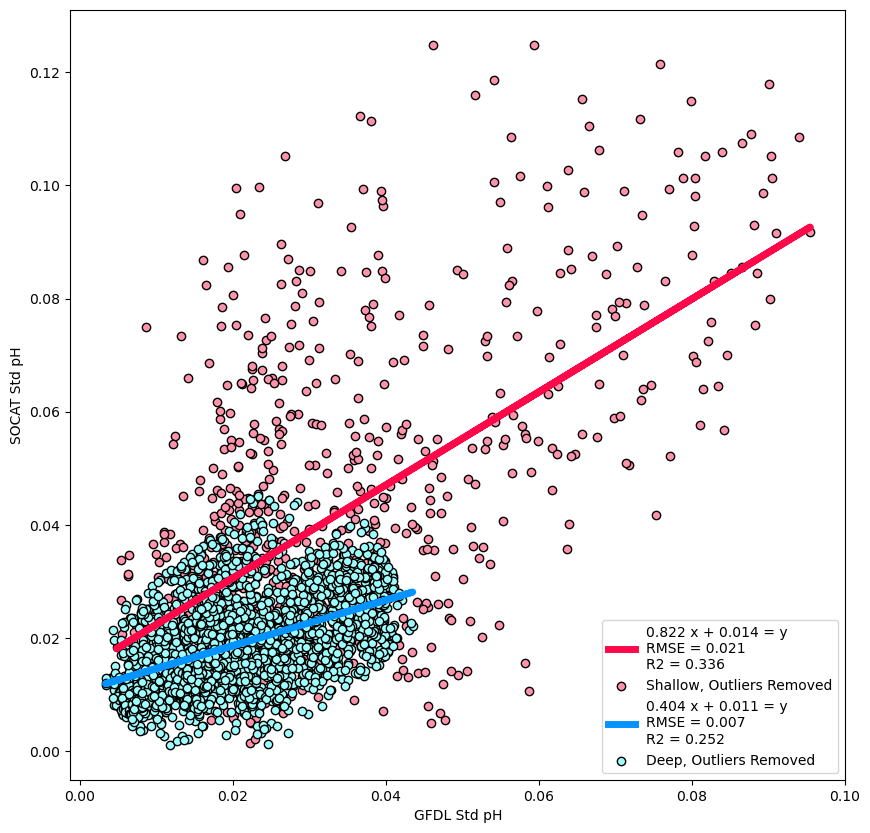

In [209]:
fig, ax = plt.subplots(figsize = [10,10])

# SHALLOW ----------------------------------------------------------------------------------------------------
x_shallow = ph_gfdl_socat_shallow['GFDL ph'].to_numpy() 
y_shallow = ph_gfdl_socat_shallow['SOCAT ph'].to_numpy()

x_shallow = x_shallow.reshape(-1,1)
regression_model_shallow = LinearRegression()
  
# Fit the data(train the model)
regression_model_shallow.fit(x_shallow, y_shallow)
  
# Predict
y_predicted_shallow = regression_model_shallow.predict(x_shallow)
  
# model evaluation
mse=mean_squared_error(y_shallow,y_predicted_shallow)
  
rmse_shallow = np.sqrt(mean_squared_error(y_shallow, y_predicted_shallow))
r2_shallow = r2_score(y_shallow, y_predicted_shallow)
cff_shallow = "%.3f" % regression_model_shallow.coef_
intcpt_shallow = "%.3f" % regression_model_shallow.intercept_
RMSE_shallow = "%.3f" % rmse_shallow
R2_shallow = "%.3f" % r2_shallow
    
lbl_shallow = cff_shallow + ' x + ' + intcpt_shallow + ' = y\nRMSE = ' + RMSE_shallow + '\nR2 = ' + R2_shallow
ax.plot(x_shallow, y_predicted_shallow, color = princess_pink[4], lw = 5, label = lbl_shallow)
ax.scatter(ph_gfdl_socat_shallow['GFDL ph'], ph_gfdl_socat_shallow['SOCAT ph'],
           facecolors = princess_pink[1], edgecolors = 'k', label = 'Shallow, Outliers Removed')
# SHALLOW ----------------------------------------------------------------------------------------------------

# DEEP -------------------------------------------------------------------------------------------------------
x_deep = ph_gfdl_socat_deep['GFDL ph'].to_numpy() 
y_deep = ph_gfdl_socat_deep['SOCAT ph'].to_numpy()

x_deep = x_deep.reshape(-1,1)
regression_model_deep = LinearRegression()
  
# Fit the data(train the model)
regression_model_deep.fit(x_deep, y_deep)
  
# Predict
y_predicted_deep = regression_model_deep.predict(x_deep)
  
# model evaluation
mse=mean_squared_error(y_deep,y_predicted_deep)
  
rmse_deep = np.sqrt(mean_squared_error(y_deep, y_predicted_deep))
r2_deep = r2_score(y_deep, y_predicted_deep)
cff_deep = "%.3f" % regression_model_deep.coef_
intcpt_deep = "%.3f" % regression_model_deep.intercept_
RMSE_deep = "%.3f" % rmse_deep
R2_deep = "%.3f" % r2_deep
    
lbl_deep = cff_deep + ' x + ' + intcpt_deep + ' = y\nRMSE = ' + RMSE_deep + '\nR2 = ' + R2_deep
ax.plot(x_deep, y_predicted_deep, color = ocean_blues[4], lw = 5, label = lbl_deep)
ax.scatter(ph_gfdl_socat_deep['GFDL ph'], ph_gfdl_socat_deep['SOCAT ph'],
           facecolors = ocean_blues[1], edgecolors = 'k', label = 'Deep, Outliers Removed')
# DEEP -------------------------------------------------------------------------------------------------------

ax.set_xlabel('GFDL Std pH')
ax.set_ylabel('SOCAT Std pH')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_SOCAT_STD_pH_NoOutliers.png', bbox_inches='tight')

# GFDL SOCAT Omega

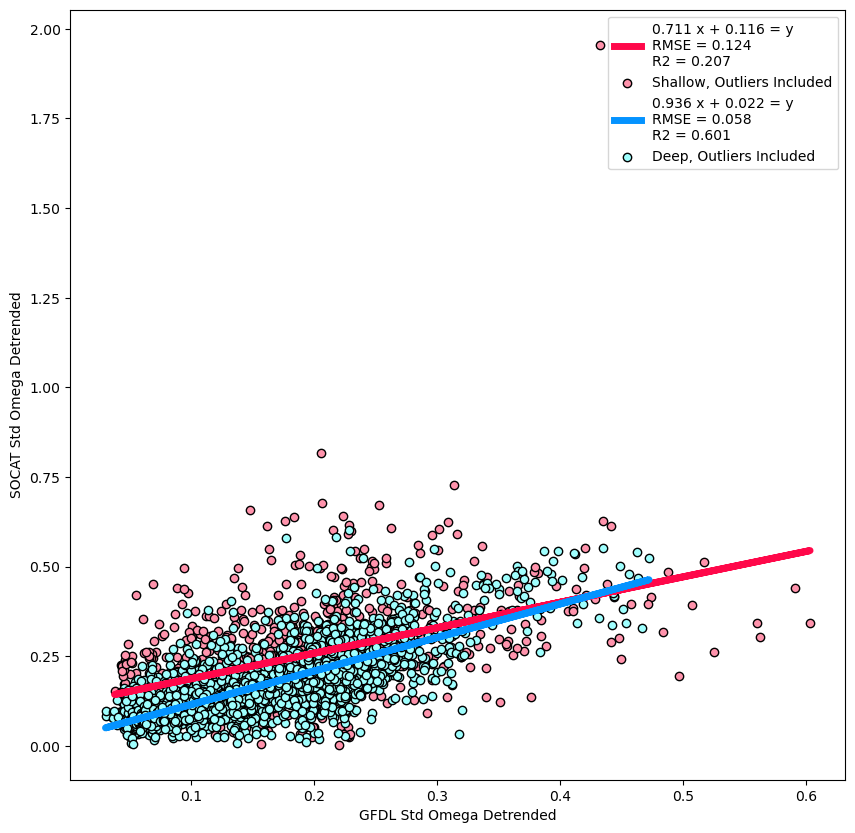

In [210]:
v = 'Omega'

fig, ax = plt.subplots(figsize = [10,10])

# SHALLOW ----------------------------------------------------------------------------------------------------
x_shallow = GFDL_SOCAT_shallow['GFDL Std ' + v + ' Detrended'].to_numpy() 
y_shallow = GFDL_SOCAT_shallow['SOCAT Std ' + v + ' Detrended'].to_numpy()

# Cook's distance as a function of GFDL fCO2
x2_shallow = sm.add_constant(x_shallow)
model_omega_GFDL_shallow = sm.OLS(y_shallow, x2_shallow).fit()
influence_omega_GFDL_shallow = model_omega_GFDL_shallow.get_influence()
inf_sum_omega_GFDL_shallow = influence_omega_GFDL_shallow.summary_frame()

# Cook's distance as a function of SOCAT fCO2
y2_shallow = sm.add_constant(y_shallow)
model_omega_SOCAT_shallow = sm.OLS(x_shallow, y2_shallow).fit() 
np.set_printoptions(suppress=True)
influence_omega_SOCAT_shallow = model_omega_SOCAT_shallow.get_influence()
inf_sum_omega_SOCAT_shallow = influence_omega_SOCAT_shallow.summary_frame()

x_shallow = x_shallow.reshape(-1,1)
regression_model_shallow = LinearRegression()
  
# Fit the data(train the model)
regression_model_shallow.fit(x_shallow, y_shallow)
  
# Predict
y_predicted_shallow = regression_model_shallow.predict(x_shallow)
  
# model evaluation
mse=mean_squared_error(y_shallow,y_predicted_shallow)
  
rmse_shallow = np.sqrt(mean_squared_error(y_shallow, y_predicted_shallow))
r2_shallow = r2_score(y_shallow, y_predicted_shallow)
cff_shallow = "%.3f" % regression_model_shallow.coef_
intcpt_shallow = "%.3f" % regression_model_shallow.intercept_
RMSE_shallow = "%.3f" % rmse_shallow
R2_shallow = "%.3f" % r2_shallow
    
lbl_shallow = cff_shallow + ' x + ' + intcpt_shallow + ' = y\nRMSE = ' + RMSE_shallow + '\nR2 = ' + R2_shallow
ax.plot(x_shallow, y_predicted_shallow, color = princess_pink[4], lw = 5, label = lbl_shallow)
ax.scatter(GFDL_SOCAT_shallow['GFDL Std ' + v + ' Detrended'], GFDL_SOCAT_shallow['SOCAT Std ' + v + ' Detrended'],
           facecolors = princess_pink[1], edgecolors = 'k', label = 'Shallow, Outliers Included')
# SHALLOW ----------------------------------------------------------------------------------------------------

# DEEP -------------------------------------------------------------------------------------------------------
x_deep = GFDL_SOCAT_deep['GFDL Std ' + v + ' Detrended'].to_numpy() 
y_deep = GFDL_SOCAT_deep['SOCAT Std ' + v + ' Detrended'].to_numpy()

# Cook's distance as a function of GFDL fCO2
x2_deep = sm.add_constant(x_deep)
model_omega_GFDL_deep = sm.OLS(y_deep, x2_deep).fit()
influence_omega_GFDL_deep = model_omega_GFDL_deep.get_influence()
inf_sum_omega_GFDL_deep = influence_omega_GFDL_deep.summary_frame()

# Cook's distance as a function of SOCAT fCO2
y2_deep = sm.add_constant(y_deep)
model_omega_SOCAT_deep = sm.OLS(x_deep, y2_deep).fit() 
influence_omega_SOCAT_deep = model_omega_SOCAT_deep.get_influence()
inf_sum_omega_SOCAT_deep = influence_omega_SOCAT_deep.summary_frame()

x_deep = x_deep.reshape(-1,1)
regression_model_deep = LinearRegression()
  
# Fit the data(train the model)
regression_model_deep.fit(x_deep, y_deep)
  
# Predict
y_predicted_deep = regression_model_deep.predict(x_deep)
  
# model evaluation
mse=mean_squared_error(y_deep,y_predicted_deep)
  
rmse_deep = np.sqrt(mean_squared_error(y_deep, y_predicted_deep))
r2_deep = r2_score(y_deep, y_predicted_deep)
cff_deep = "%.3f" % regression_model_deep.coef_
intcpt_deep = "%.3f" % regression_model_deep.intercept_
RMSE_deep = "%.3f" % rmse_deep
R2_deep = "%.3f" % r2_deep
    
lbl_deep = cff_deep + ' x + ' + intcpt_deep + ' = y\nRMSE = ' + RMSE_deep + '\nR2 = ' + R2_deep
ax.plot(x_deep, y_predicted_deep, color = ocean_blues[4], lw = 5, label = lbl_deep)
ax.scatter(GFDL_SOCAT_deep['GFDL Std ' + v + ' Detrended'], GFDL_SOCAT_deep['SOCAT Std ' + v + ' Detrended'],
           facecolors = ocean_blues[1], edgecolors = 'k', label = 'Deep, Outliers Included')
# DEEP -------------------------------------------------------------------------------------------------------

ax.set_xlabel('GFDL Std ' + v + ' Detrended')
ax.set_ylabel('SOCAT Std ' + v + ' Detrended')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_SOCAT_STD_Omega_Outliers.png', bbox_inches='tight')

## Filter out outliers based on Cook's distance

In [211]:
omega_gfdl_socat_shallow = {'Lat': [], 'Lon': [], 'GFDL omega': [], 'SOCAT omega': [], 'Cooks GFDL': [], 'Cooks SOCAT': []}

for i in GFDL_SOCAT_shallow.index:
    omega_gfdl_socat_shallow['Lat'].append(GFDL_SOCAT_shallow['Lat'][i])
    omega_gfdl_socat_shallow['Lon'].append(GFDL_SOCAT_shallow['Lon'][i])
    omega_gfdl_socat_shallow['GFDL omega'].append(GFDL_SOCAT_shallow['GFDL Std Omega Detrended'][i])
    omega_gfdl_socat_shallow['SOCAT omega'].append(GFDL_SOCAT_shallow['SOCAT Std Omega Detrended'][i])
    omega_gfdl_socat_shallow['Cooks GFDL'].append(inf_sum_omega_GFDL_shallow['cooks_d'][i])
    omega_gfdl_socat_shallow['Cooks SOCAT'].append(inf_sum_omega_SOCAT_shallow['cooks_d'][i])
    
omega_gfdl_socat_shallow = pd.DataFrame(omega_gfdl_socat_shallow)
omega_gfdl_socat_shallow = omega_gfdl_socat_shallow.where(omega_gfdl_socat_shallow['Cooks GFDL'] <=
                                                        3*omega_gfdl_socat_shallow['Cooks GFDL'].mean()).dropna()
omega_gfdl_socat_shallow = omega_gfdl_socat_shallow.where(omega_gfdl_socat_shallow['Cooks SOCAT'] <=
                                                        3*omega_gfdl_socat_shallow['Cooks SOCAT'].mean()).dropna()

In [212]:
omega_gfdl_socat_deep = {'Lat': [], 'Lon': [], 'GFDL omega': [], 'SOCAT omega': [], 'Cooks GFDL': [], 'Cooks SOCAT': []}

for i in GFDL_SOCAT_deep.index:
    omega_gfdl_socat_deep['Lat'].append(GFDL_SOCAT_deep['Lat'][i])
    omega_gfdl_socat_deep['Lon'].append(GFDL_SOCAT_deep['Lon'][i])
    omega_gfdl_socat_deep['GFDL omega'].append(GFDL_SOCAT_deep['GFDL Std Omega Detrended'][i])
    omega_gfdl_socat_deep['SOCAT omega'].append(GFDL_SOCAT_deep['SOCAT Std Omega Detrended'][i])
    omega_gfdl_socat_deep['Cooks GFDL'].append(inf_sum_omega_GFDL_deep['cooks_d'][i])
    omega_gfdl_socat_deep['Cooks SOCAT'].append(inf_sum_omega_SOCAT_deep['cooks_d'][i])
    
omega_gfdl_socat_deep = pd.DataFrame(omega_gfdl_socat_deep)
omega_gfdl_socat_deep = omega_gfdl_socat_deep.where(omega_gfdl_socat_deep['Cooks GFDL'] <=
                                                        3*omega_gfdl_socat_deep['Cooks GFDL'].mean()).dropna()
omega_gfdl_socat_deep = omega_gfdl_socat_deep.where(omega_gfdl_socat_deep['Cooks SOCAT'] <=
                                                        3*omega_gfdl_socat_deep['Cooks SOCAT'].mean()).dropna()

## GFDL SOCAT Omega outliers removed

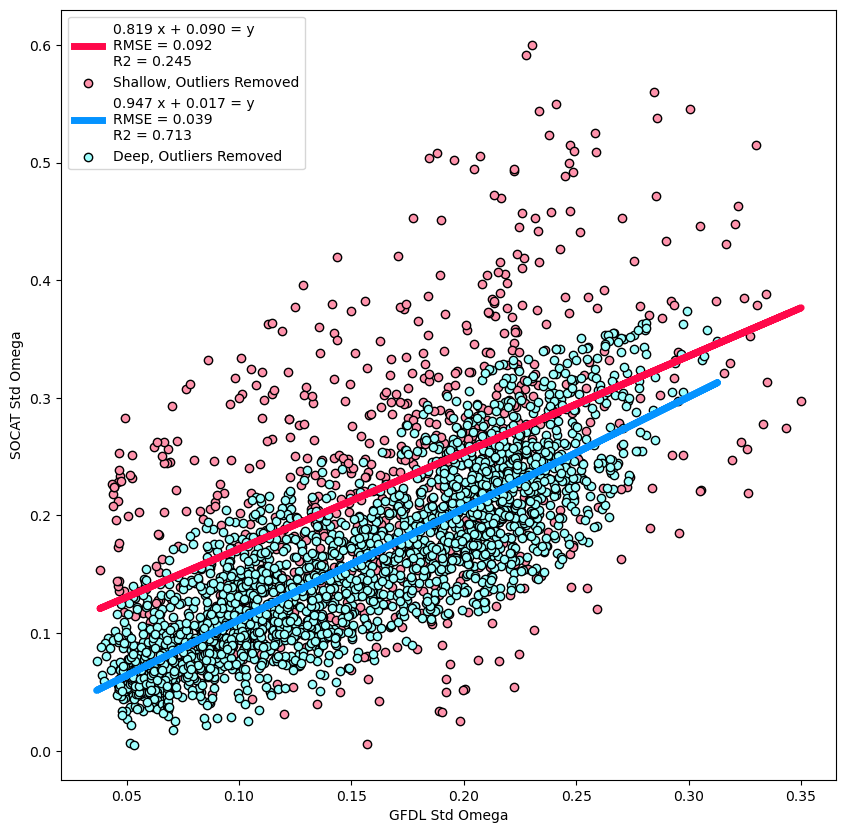

In [213]:
fig, ax = plt.subplots(figsize = [10,10])

# SHALLOW ----------------------------------------------------------------------------------------------------
x_shallow = omega_gfdl_socat_shallow['GFDL omega'].to_numpy() 
y_shallow = omega_gfdl_socat_shallow['SOCAT omega'].to_numpy()

x_shallow = x_shallow.reshape(-1,1)
regression_model_shallow = LinearRegression()
  
# Fit the data(train the model)
regression_model_shallow.fit(x_shallow, y_shallow)
  
# Predict
y_predicted_shallow = regression_model_shallow.predict(x_shallow)
  
# model evaluation
mse=mean_squared_error(y_shallow,y_predicted_shallow)
  
rmse_shallow = np.sqrt(mean_squared_error(y_shallow, y_predicted_shallow))
r2_shallow = r2_score(y_shallow, y_predicted_shallow)
cff_shallow = "%.3f" % regression_model_shallow.coef_
intcpt_shallow = "%.3f" % regression_model_shallow.intercept_
RMSE_shallow = "%.3f" % rmse_shallow
R2_shallow = "%.3f" % r2_shallow
    
lbl_shallow = cff_shallow + ' x + ' + intcpt_shallow + ' = y\nRMSE = ' + RMSE_shallow + '\nR2 = ' + R2_shallow
ax.plot(x_shallow, y_predicted_shallow, color = princess_pink[4], lw = 5, label = lbl_shallow)
ax.scatter(omega_gfdl_socat_shallow['GFDL omega'], omega_gfdl_socat_shallow['SOCAT omega'],
           facecolors = princess_pink[1], edgecolors = 'k', label = 'Shallow, Outliers Removed')
# SHALLOW ----------------------------------------------------------------------------------------------------

# DEEP -------------------------------------------------------------------------------------------------------
x_deep = omega_gfdl_socat_deep['GFDL omega'].to_numpy() 
y_deep = omega_gfdl_socat_deep['SOCAT omega'].to_numpy()

x_deep = x_deep.reshape(-1,1)
regression_model_deep = LinearRegression()
  
# Fit the data(train the model)
regression_model_deep.fit(x_deep, y_deep)
  
# Predict
y_predicted_deep = regression_model_deep.predict(x_deep)
  
# model evaluation
mse=mean_squared_error(y_deep,y_predicted_deep)
  
rmse_deep = np.sqrt(mean_squared_error(y_deep, y_predicted_deep))
r2_deep = r2_score(y_deep, y_predicted_deep)
cff_deep = "%.3f" % regression_model_deep.coef_
intcpt_deep = "%.3f" % regression_model_deep.intercept_
RMSE_deep = "%.3f" % rmse_deep
R2_deep = "%.3f" % r2_deep
    
lbl_deep = cff_deep + ' x + ' + intcpt_deep + ' = y\nRMSE = ' + RMSE_deep + '\nR2 = ' + R2_deep
ax.plot(x_deep, y_predicted_deep, color = ocean_blues[4], lw = 5, label = lbl_deep)
ax.scatter(omega_gfdl_socat_deep['GFDL omega'], omega_gfdl_socat_deep['SOCAT omega'],
           facecolors = ocean_blues[1], edgecolors = 'k', label = 'Deep, Outliers Removed')
# DEEP -------------------------------------------------------------------------------------------------------

ax.set_xlabel('GFDL Std Omega')
ax.set_ylabel('SOCAT Std Omega')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_SOCAT_STD_Omega_NoOutliers.png', bbox_inches='tight')

# GFDL + Buoys

In [155]:
GFDL_buoys = pd.read_csv('/Users/akbaskind/Desktop/YoE/allbuoys_GFDL.csv')
# GFDL_buoys.to_csv('/Users/akbaskind/Documents/Python Scripts/YoE/allbuoys_GFD_June18.csv')

In [161]:
GFDL_buoys = GFDL_buoys.dropna()
GFDL_buoys = GFDL_buoys.reset_index(drop=True)

## Linear Regression: GFDL + Buoys w/ Outliers

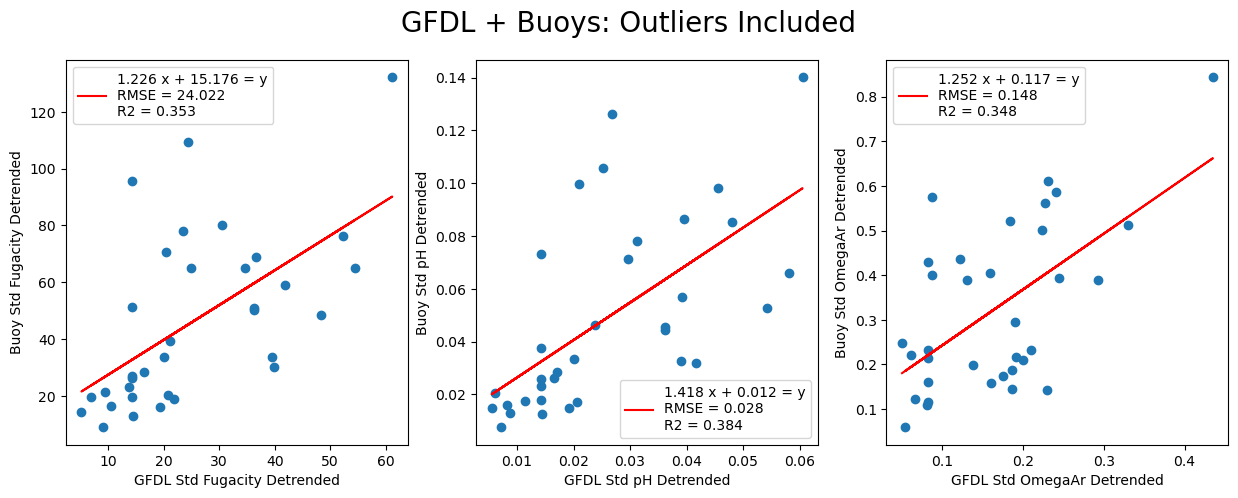

In [233]:
fig, axarr = plt.subplots(ncols = 3, figsize = [15,5])
ax_idx = 0
var = ['Fugacity', 'pH', 'OmegaAr']

for v in var:
    ax = axarr.flat[ax_idx]
    ax.scatter(GFDL_buoys['GFDL Std ' + v + ' Detrended'], GFDL_buoys['Buoy Std ' + v + ' Detrended'])
    ax.set_xlabel('GFDL Std ' + v + ' Detrended')
    ax.set_ylabel('Buoy Std ' + v + ' Detrended')
    
    # Prep for linear regression
    x = GFDL_buoys['GFDL Std ' + v + ' Detrended'].to_numpy() 
    y = GFDL_buoys['Buoy Std ' + v + ' Detrended'].to_numpy()
    n = np.size(x)
    
    x = x.reshape(-1,1)
    regression_model = LinearRegression()
  
    # Fit the data(train the model)
    regression_model.fit(x, y)
  
    # Predict
    y_predicted = regression_model.predict(x)
  
    # model evaluation
    mse=mean_squared_error(y,y_predicted)
  
    rmse = np.sqrt(mean_squared_error(y, y_predicted))
    r2 = r2_score(y, y_predicted)
    cff = "%.3f" % regression_model.coef_
    intcpt = "%.3f" % regression_model.intercept_
    RMSE = "%.3f" % rmse
    R2 = "%.3f" % r2
    
    lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
    ax.plot(x, y_predicted, color = 'red', label = lbl)
    ax.legend()
    
    ax_idx += 1

fig.suptitle('GFDL + Buoys: Outliers Included', fontsize=20)
# fig.suptitle('GFDL + SOCAT: Outliers Included', fontsize=20)
fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_Buoy_STD_All_Outliers.png', bbox_inches='tight')

# GFDL Buoy fCO2

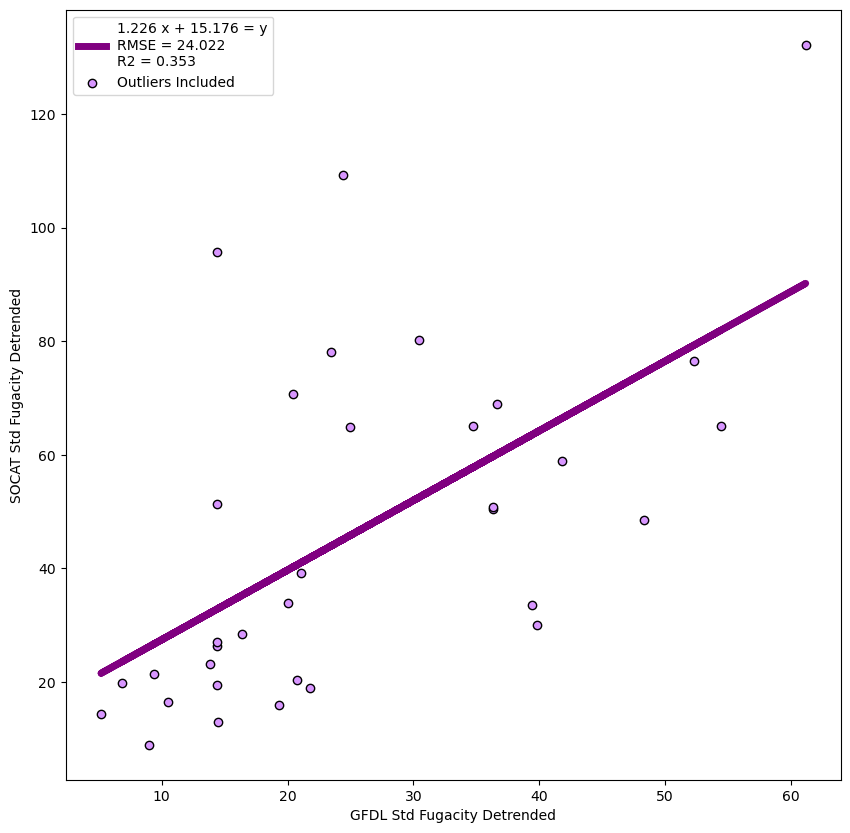

In [223]:
v = 'Fugacity'

fig, ax = plt.subplots(figsize = [10,10])

x = GFDL_buoys['GFDL Std ' + v + ' Detrended'].to_numpy() 
y = GFDL_buoys['Buoy Std ' + v + ' Detrended'].to_numpy()

# Cook's distance as a function of GFDL fCO2
x2 = sm.add_constant(x)
model_fCO2_GFDL = sm.OLS(y, x2).fit()
influence_fCO2_GFDL = model_fCO2_GFDL.get_influence()
inf_sum_fCO2_GFDL = influence_fCO2_GFDL.summary_frame()

# Cook's distance as a function of SOCAT fCO2
y2 = sm.add_constant(y)
model_fCO2_buoy = sm.OLS(x, y2).fit() 
np.set_printoptions(suppress=True)
influence_fCO2_buoy = model_fCO2_buoy.get_influence()
inf_sum_fCO2_buoy = influence_fCO2_buoy.summary_frame()

x = x.reshape(-1,1)
regression_model = LinearRegression()
  
# Fit the data(train the model)
regression_model.fit(x, y)
  
# Predict
y_predicted = regression_model.predict(x)
  
# model evaluation
mse=mean_squared_error(y,y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)
cff = "%.3f" % regression_model.coef_
intcpt = "%.3f" % regression_model.intercept_
RMSE = "%.3f" % rmse
R2 = "%.3f" % r2
    
lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
ax.plot(x, y_predicted, color = purples[3], lw = 5, label = lbl)
ax.scatter(GFDL_buoys['GFDL Std ' + v + ' Detrended'], GFDL_buoys['Buoy Std ' + v + ' Detrended'],
           facecolors = purples[1], edgecolors = 'k', label = 'Outliers Included')

ax.set_xlabel('GFDL Std ' + v + ' Detrended')
ax.set_ylabel('SOCAT Std ' + v + ' Detrended')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_Buoy_STD_fCO2_Outliers.png', bbox_inches='tight')

In [224]:
fco2_gfdl_buoy = {'Lat': [], 'Lon': [], 'GFDL fco2': [], 'Buoy fco2': [], 'Cooks GFDL': [], 'Cooks Buoy': []}

for i in GFDL_buoys.index:
    fco2_gfdl_buoy['Lat'].append(GFDL_buoys['Lat'][i])
    fco2_gfdl_buoy['Lon'].append(GFDL_buoys['Lon'][i])
    fco2_gfdl_buoy['GFDL fco2'].append(GFDL_buoys['GFDL Std Fugacity Detrended'][i])
    fco2_gfdl_buoy['Buoy fco2'].append(GFDL_buoys['Buoy Std Fugacity Detrended'][i])
    fco2_gfdl_buoy['Cooks GFDL'].append(inf_sum_fCO2_GFDL['cooks_d'][i])
    fco2_gfdl_buoy['Cooks Buoy'].append(inf_sum_fCO2_buoy['cooks_d'][i])
    
fco2_gfdl_buoy = pd.DataFrame(fco2_gfdl_buoy)
fco2_gfdl_buoy = fco2_gfdl_buoy.where(fco2_gfdl_buoy['Cooks GFDL'] <=
                                                        3*fco2_gfdl_buoy['Cooks GFDL'].mean()).dropna()
fco2_gfdl_buoy = fco2_gfdl_buoy.where(fco2_gfdl_buoy['Cooks Buoy'] <=
                                                        3*fco2_gfdl_buoy['Cooks Buoy'].mean()).dropna()

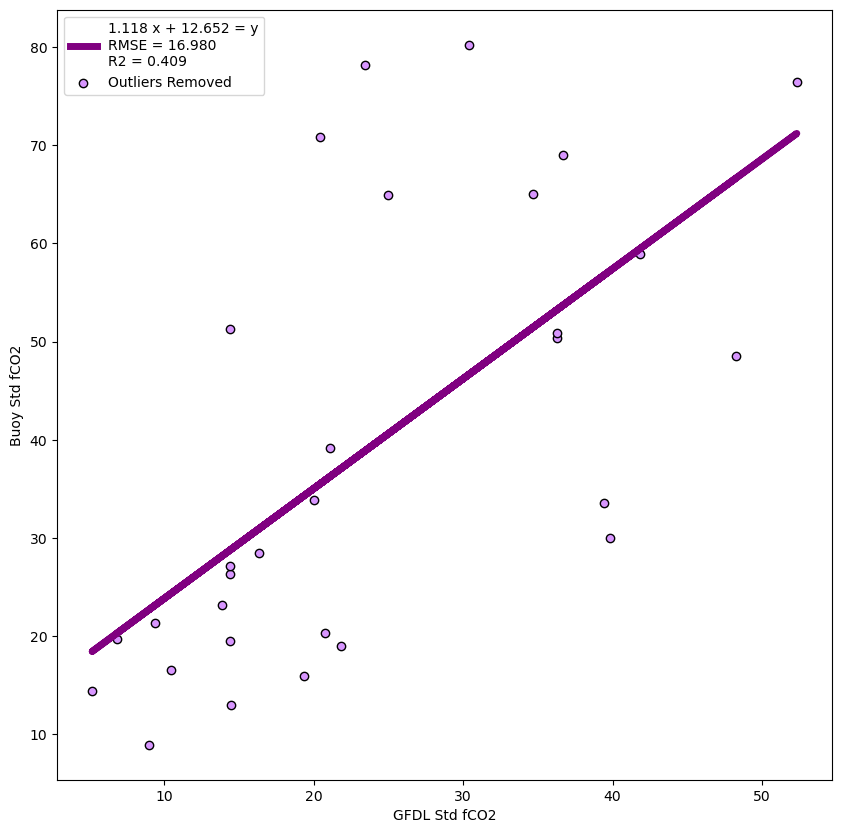

In [226]:
fig, ax = plt.subplots(figsize = [10,10])

x = fco2_gfdl_buoy['GFDL fco2'].to_numpy() 
y = fco2_gfdl_buoy['Buoy fco2'].to_numpy()

x = x.reshape(-1,1)
regression_model = LinearRegression()
  
# Fit the data(train the model)
regression_model.fit(x, y)
  
# Predict
y_predicted = regression_model.predict(x)
  
# model evaluation
mse=mean_squared_error(y,y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)
cff = "%.3f" % regression_model.coef_
intcpt = "%.3f" % regression_model.intercept_
RMSE = "%.3f" % rmse
R2 = "%.3f" % r2
    
lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
ax.plot(x, y_predicted, color = purples[3], lw = 5, label = lbl)
ax.scatter(fco2_gfdl_buoy['GFDL fco2'], fco2_gfdl_buoy['Buoy fco2'],
           facecolors = purples[1], edgecolors = 'k', label = 'Outliers Removed')

ax.set_xlabel('GFDL Std fCO2')
ax.set_ylabel('Buoy Std fCO2')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_Buoy_STD_fCO2_NoOutliers.png', bbox_inches='tight')

# GFDL Buoy pH

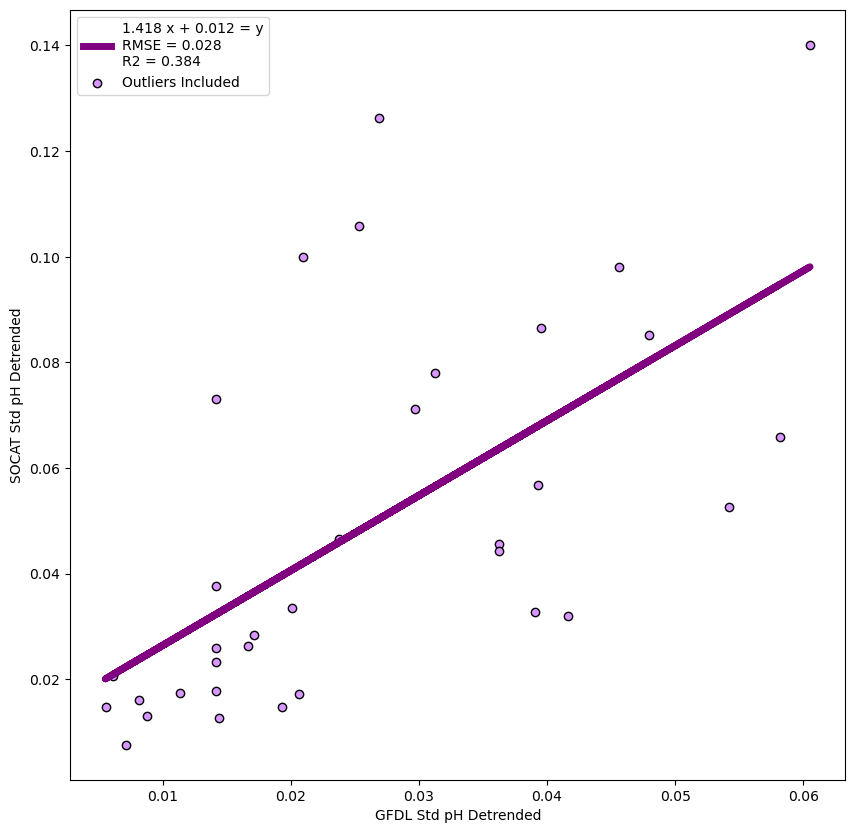

In [227]:
v = 'pH'

fig, ax = plt.subplots(figsize = [10,10])

x = GFDL_buoys['GFDL Std ' + v + ' Detrended'].to_numpy() 
y = GFDL_buoys['Buoy Std ' + v + ' Detrended'].to_numpy()

# Cook's distance as a function of GFDL fCO2
x2 = sm.add_constant(x)
model_ph_GFDL = sm.OLS(y, x2).fit()
influence_ph_GFDL = model_ph_GFDL.get_influence()
inf_sum_ph_GFDL = influence_ph_GFDL.summary_frame()

# Cook's distance as a function of SOCAT fCO2
y2 = sm.add_constant(y)
model_ph_buoy = sm.OLS(x, y2).fit() 
np.set_printoptions(suppress=True)
influence_ph_buoy = model_ph_buoy.get_influence()
inf_sum_ph_buoy = influence_ph_buoy.summary_frame()

x = x.reshape(-1,1)
regression_model = LinearRegression()
  
# Fit the data(train the model)
regression_model.fit(x, y)
  
# Predict
y_predicted = regression_model.predict(x)
  
# model evaluation
mse=mean_squared_error(y,y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)
cff = "%.3f" % regression_model.coef_
intcpt = "%.3f" % regression_model.intercept_
RMSE = "%.3f" % rmse
R2 = "%.3f" % r2
    
lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
ax.plot(x, y_predicted, color = purples[3], lw = 5, label = lbl)
ax.scatter(GFDL_buoys['GFDL Std ' + v + ' Detrended'], GFDL_buoys['Buoy Std ' + v + ' Detrended'],
           facecolors = purples[1], edgecolors = 'k', label = 'Outliers Included')

ax.set_xlabel('GFDL Std ' + v + ' Detrended')
ax.set_ylabel('SOCAT Std ' + v + ' Detrended')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_Buoy_STD_pH_Outliers.png', bbox_inches='tight')

In [228]:
ph_gfdl_buoy = {'Lat': [], 'Lon': [], 'GFDL ph': [], 'Buoy ph': [], 'Cooks GFDL': [], 'Cooks Buoy': []}

for i in GFDL_buoys.index:
    ph_gfdl_buoy['Lat'].append(GFDL_buoys['Lat'][i])
    ph_gfdl_buoy['Lon'].append(GFDL_buoys['Lon'][i])
    ph_gfdl_buoy['GFDL ph'].append(GFDL_buoys['GFDL Std pH Detrended'][i])
    ph_gfdl_buoy['Buoy ph'].append(GFDL_buoys['Buoy Std pH Detrended'][i])
    ph_gfdl_buoy['Cooks GFDL'].append(inf_sum_ph_GFDL['cooks_d'][i])
    ph_gfdl_buoy['Cooks Buoy'].append(inf_sum_ph_buoy['cooks_d'][i])
    
ph_gfdl_buoy = pd.DataFrame(ph_gfdl_buoy)
ph_gfdl_buoy = ph_gfdl_buoy.where(ph_gfdl_buoy['Cooks GFDL'] <=
                                                        3*ph_gfdl_buoy['Cooks GFDL'].mean()).dropna()
ph_gfdl_buoy = ph_gfdl_buoy.where(ph_gfdl_buoy['Cooks Buoy'] <=
                                                        3*ph_gfdl_buoy['Cooks Buoy'].mean()).dropna()

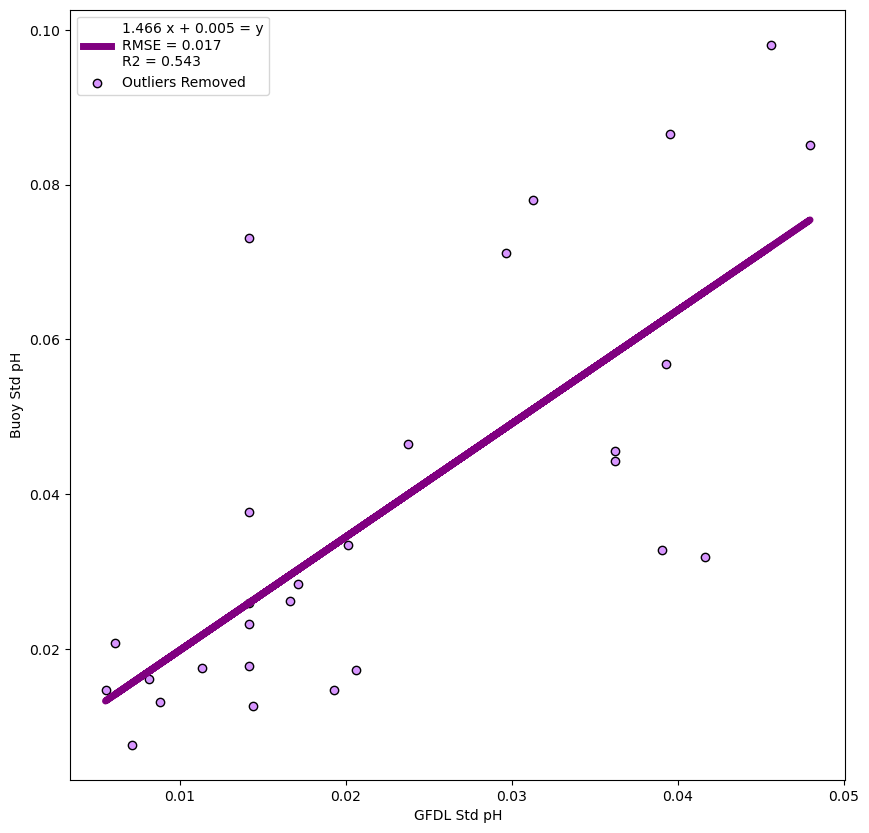

In [229]:
fig, ax = plt.subplots(figsize = [10,10])

x = ph_gfdl_buoy['GFDL ph'].to_numpy() 
y = ph_gfdl_buoy['Buoy ph'].to_numpy()

x = x.reshape(-1,1)
regression_model = LinearRegression()
  
# Fit the data(train the model)
regression_model.fit(x, y)
  
# Predict
y_predicted = regression_model.predict(x)
  
# model evaluation
mse=mean_squared_error(y,y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)
cff = "%.3f" % regression_model.coef_
intcpt = "%.3f" % regression_model.intercept_
RMSE = "%.3f" % rmse
R2 = "%.3f" % r2
    
lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
ax.plot(x, y_predicted, color = purples[3], lw = 5, label = lbl)
ax.scatter(ph_gfdl_buoy['GFDL ph'], ph_gfdl_buoy['Buoy ph'],
           facecolors = purples[1], edgecolors = 'k', label = 'Outliers Removed')

ax.set_xlabel('GFDL Std pH')
ax.set_ylabel('Buoy Std pH')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_Buoy_STD_pH_NoOutliers.png', bbox_inches='tight')

# GFDL Buoy Omega

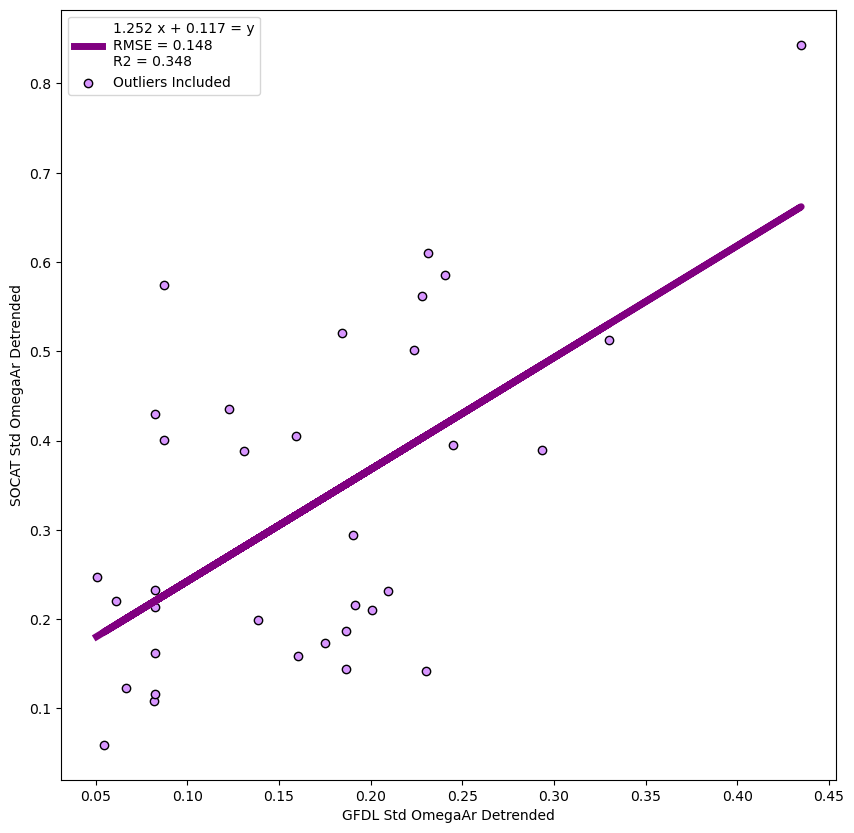

In [230]:
v = 'OmegaAr'

fig, ax = plt.subplots(figsize = [10,10])

x = GFDL_buoys['GFDL Std ' + v + ' Detrended'].to_numpy() 
y = GFDL_buoys['Buoy Std ' + v + ' Detrended'].to_numpy()

# Cook's distance as a function of GFDL fCO2
x2 = sm.add_constant(x)
model_omega_GFDL = sm.OLS(y, x2).fit()
influence_omega_GFDL = model_omega_GFDL.get_influence()
inf_sum_omega_GFDL = influence_omega_GFDL.summary_frame()

# Cook's distance as a function of SOCAT fCO2
y2 = sm.add_constant(y)
model_omega_buoy = sm.OLS(x, y2).fit() 
np.set_printoptions(suppress=True)
influence_omega_buoy = model_omega_buoy.get_influence()
inf_sum_omega_buoy = influence_omega_buoy.summary_frame()

x = x.reshape(-1,1)
regression_model = LinearRegression()
  
# Fit the data(train the model)
regression_model.fit(x, y)
  
# Predict
y_predicted = regression_model.predict(x)
  
# model evaluation
mse=mean_squared_error(y,y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)
cff = "%.3f" % regression_model.coef_
intcpt = "%.3f" % regression_model.intercept_
RMSE = "%.3f" % rmse
R2 = "%.3f" % r2
    
lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
ax.plot(x, y_predicted, color = purples[3], lw = 5, label = lbl)
ax.scatter(GFDL_buoys['GFDL Std ' + v + ' Detrended'], GFDL_buoys['Buoy Std ' + v + ' Detrended'],
           facecolors = purples[1], edgecolors = 'k', label = 'Outliers Included')

ax.set_xlabel('GFDL Std ' + v + ' Detrended')
ax.set_ylabel('SOCAT Std ' + v + ' Detrended')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_Buoy_STD_Omega_Outliers.png', bbox_inches='tight')

In [231]:
omega_gfdl_buoy = {'Lat': [], 'Lon': [], 'GFDL omega': [], 'Buoy omega': [], 'Cooks GFDL': [], 'Cooks Buoy': []}

for i in GFDL_buoys.index:
    omega_gfdl_buoy['Lat'].append(GFDL_buoys['Lat'][i])
    omega_gfdl_buoy['Lon'].append(GFDL_buoys['Lon'][i])
    omega_gfdl_buoy['GFDL omega'].append(GFDL_buoys['GFDL Std OmegaAr Detrended'][i])
    omega_gfdl_buoy['Buoy omega'].append(GFDL_buoys['Buoy Std OmegaAr Detrended'][i])
    omega_gfdl_buoy['Cooks GFDL'].append(inf_sum_omega_GFDL['cooks_d'][i])
    omega_gfdl_buoy['Cooks Buoy'].append(inf_sum_omega_buoy['cooks_d'][i])
    
omega_gfdl_buoy = pd.DataFrame(omega_gfdl_buoy)
omega_gfdl_buoy = omega_gfdl_buoy.where(omega_gfdl_buoy['Cooks GFDL'] <=
                                                        3*omega_gfdl_buoy['Cooks GFDL'].mean()).dropna()
omega_gfdl_buoy = omega_gfdl_buoy.where(omega_gfdl_buoy['Cooks Buoy'] <=
                                                        3*omega_gfdl_buoy['Cooks Buoy'].mean()).dropna()

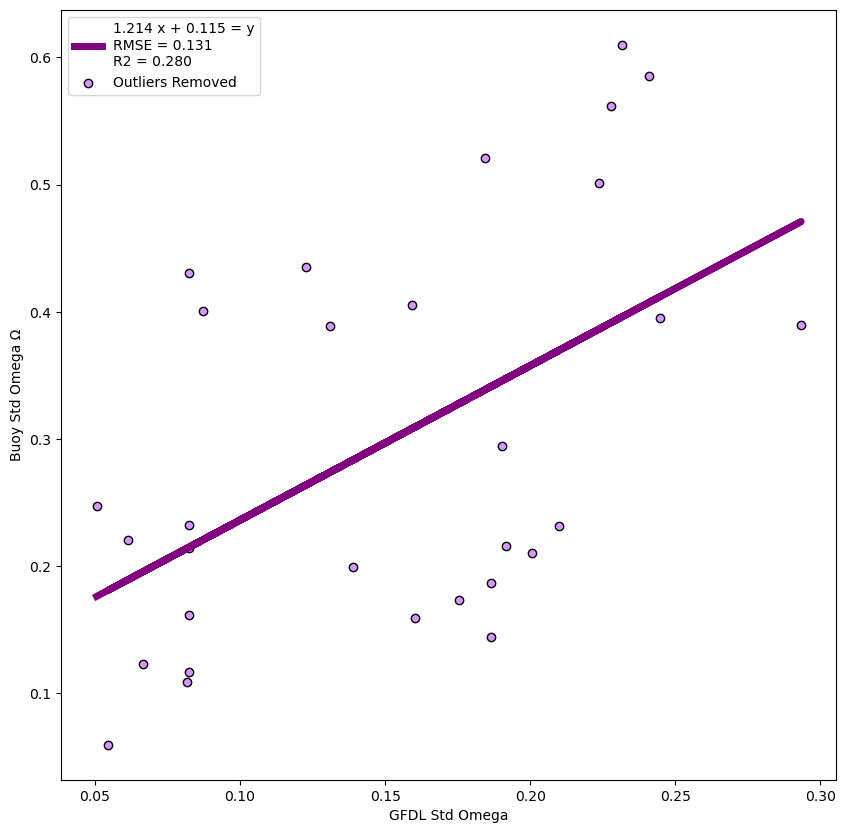

In [232]:
fig, ax = plt.subplots(figsize = [10,10])

x = omega_gfdl_buoy['GFDL omega'].to_numpy() 
y = omega_gfdl_buoy['Buoy omega'].to_numpy()

x = x.reshape(-1,1)
regression_model = LinearRegression()
  
# Fit the data(train the model)
regression_model.fit(x, y)
  
# Predict
y_predicted = regression_model.predict(x)
  
# model evaluation
mse=mean_squared_error(y,y_predicted)
  
rmse = np.sqrt(mean_squared_error(y, y_predicted))
r2 = r2_score(y, y_predicted)
cff = "%.3f" % regression_model.coef_
intcpt = "%.3f" % regression_model.intercept_
RMSE = "%.3f" % rmse
R2 = "%.3f" % r2
    
lbl = cff + ' x + ' + intcpt + ' = y\nRMSE = ' + RMSE + '\nR2 = ' + R2
ax.plot(x, y_predicted, color = purples[3], lw = 5, label = lbl)
ax.scatter(omega_gfdl_buoy['GFDL omega'], omega_gfdl_buoy['Buoy omega'],
           facecolors = purples[1], edgecolors = 'k', label = 'Outliers Removed')

ax.set_xlabel('GFDL Std Omega')
ax.set_ylabel('Buoy Std Omega Ω')
ax.legend()

fig.savefig('/Users/akbaskind/Documents/Python Scripts/YOE/GFDL_Buoy_STD_Omega_NoOutliers.png', bbox_inches='tight')

# So here's the vision...

Where variability is available from real world data (i.e. SOCAT or PMEL buoys), I will use that. Where *only* GFDL data is available, I will adjust that modeled variability based on the linear correlations with real world observations. 

When I adjust variability for GFDL-only locations, I will weight the adjustment based on the strength of the correlation.

In [177]:
ds = xr.open_mfdataset('/Users/akbaskind/Desktop/YoE/GFDLESM4historical_1995_2015.nc')
ds['fCO2_detrended'] = (ds['fCO2'] -  1.89 * (ds['fCO2'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds['ph_detrended'] = (ds['phos'] + 0.0018 * (ds['phos'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
ds['OmegaAr_detrended'] = (ds['OmegaAr'] + 0.0078 * (ds['OmegaAr'].time.dt.year - 2000)) * xr.ones_like(ds['talkos'])
# ds['fugacity_detrended'] = xr.Variable(dims = ['time','y', 'x'], data = ds['fugacity'] -  1.89 * (ds['fugacity'].time.dt.year - 1980))
ds['fCO2_detrended'].attrs = {"units": 'uatm', 
                        'description': 'detrended fugacity. 1.89 uatm subtracted for every year since 2000',
                                 'name': 'fugacity detrended'}
ds['ph_detrended'].attrs = {"units": '', 'name': 'pH detrended', 
                        'description': 'detrended pH on total scale. 0.0018 added for every year since 2000'}
ds['OmegaAr_detrended'].attrs = {"units": '', 'name': 'Omega_arag detrended', 
                        'description': 'detrended Omega_arag calculated from PyCO2SYS: 0.0078 added for every year since 2000'}
dsmean = ds.mean('time', keep_attrs = True)
dsstd = ds.std('time', keep_attrs = True)

In [178]:
dsstd

<xarray.Dataset>
Dimensions:            (y: 180, x: 360)
Coordinates:
  * y                  (y) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    lat_bounds         (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    lon_bounds         (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat                (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lon_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    lat_verticies      (x, y) float64 dask.array<chunksize=(360, 180), meta=np.ndarray>
    member_id          object ...
    dcpp_init_year     float64 ...
Data variables:
    sos                (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    dissicos           (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    phos               (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    tos                (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    talkos             (y, x) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    sigma0             (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    fCO2               (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    OmegaAr            (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    fCO2_detrended     (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    ph_detrended       (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    OmegaAr_detrended  (y, x) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                      CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            36500.0
    comment:                          <null ref>
    ...                               ...
    intake_esm_attrs:experiment_id:   historical
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Omon
    intake_esm_attrs:grid_label:      gr
    intake_esm_attrs:version:         20190726
    intake_esm_attrs:_data_format_:   zarr

In [179]:
da = xr.open_mfdataset('/Users/akbaskind/Documents/Python Scripts/YoE/SOCAT_akb_June24.nc')

In [180]:
da

<xarray.Dataset>
Dimensions:               (lat: 180, lon: 360)
Coordinates:
  * lat                   (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                   (lon) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables:
    StdpH                 (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    minYr                 (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    maxYr                 (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    UniqueYrs             (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    StdfCO2               (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    StdOmegaAr            (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    StdpH_detrended       (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    StdfCO2_detrended     (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>
    StdOmegaAr_detrended  (lat, lon) float64 dask.array<chunksize=(180, 360), meta=np.ndarray>

In [38]:
temp = {'Lat':[], 'Lon': [], 'GFDL Std Fugacity Detrended': [], 'SOCAT Std Fugacity Detrended': [],
       'GFDL Std pH Detrended': [], 'SOCAT Std pH Detrended': [],
       'GFDL Std Omega Detrended': [], 'SOCAT Std Omega Detrended': []}
for i in np.arange(-89.5,90,1):
    for j in np.arange(0.5,360,1):
        # dd.lat.values:
        if math.isnan(dsstd['fCO2_detrended'].sel(x = j, y = i, method = 'nearest').values.tolist()) == False:
            temp['Lon'].append(j)
            temp['Lat'].append(i)
            temp['GFDL Std Fugacity Detrended'].append(dsstd['fCO2_detrended'].sel(x = j, y = i, method = 'nearest').values.tolist())
            # temp['SOCAT Std Fugacity Detrended'].append(da['StdfCO2_detrended'].sel(lon = j, lat = i).values.tolist())
            temp['GFDL Std pH Detrended'].append(dsstd['ph_detrended'].sel(x = j, y = i, method = 'nearest').values.tolist())
            # temp['SOCAT Std pH Detrended'].append(da['StdpH_detrended'].sel(lon = j, lat = i).values.tolist())
            temp['GFDL Std Omega Detrended'].append(dsstd['OmegaAr_detrended'].sel(x = j, y = i, method = 'nearest').values.tolist())
            # temp['SOCAT Std Omega Detrended'].append(da['StdOmegaAr_detrended'].sel(lon = j, lat = i).values.tolist())
            if math.isnan(da['StdfCO2_detrended'].sel(lon = j, lat = i).values.tolist()) == False:
                temp['SOCAT Std Fugacity Detrended'].append(da['StdfCO2_detrended'].sel(lon = j, lat = i).values.tolist())
                temp['SOCAT Std pH Detrended'].append(da['StdpH_detrended'].sel(lon = j, lat = i).values.tolist())
                temp['SOCAT Std Omega Detrended'].append(da['StdOmegaAr_detrended'].sel(lon = j, lat = i).values.tolist())
            else:
                temp['SOCAT Std Fugacity Detrended'].append(np.nan)
                temp['SOCAT Std pH Detrended'].append(np.nan)
                temp['SOCAT Std Omega Detrended'].append(np.nan)

In [39]:
tempdf = pd.DataFrame(temp)

In [41]:
tempdf.to_csv('/Users/akbaskind/Desktop/YoE/GFDLESM4_SOCAT_ALL.csv')

In [181]:
ddict = pd.read_csv('/Users/akbaskind/Desktop/YoE/GFDLESM4_SOCAT_BUOY_ALL.csv')
ddict

,Lat,Lon,GFDL Std Fugacity Detrended,SOCAT Std Fugacity Detrended,Buoy Std Fugacity Detrended,GFDL Std pH Detrended,SOCAT Std pH Detrended,Buoy Std pH Detrended,GFDL Std Omega Detrended,SOCAT Std Omega Detrended,Buoy Std Omega Detrended
0,-77.5,162.5,65.564805,NaN,NaN,0.100497,NaN,NaN,0.335283,NaN,NaN
1,-77.5,163.5,78.319279,NaN,NaN,0.129836,NaN,NaN,0.475641,NaN,NaN
2,-77.5,164.5,75.990631,NaN,NaN,0.122909,NaN,NaN,0.460786,NaN,NaN
3,-77.5,165.5,70.439747,32.139,NaN,0.111884,0.053945,NaN,0.449691,0.24297,NaN
4,-77.5,166.5,72.004162,39.865,NaN,0.111023,0.069021,NaN,0.447630,0.30103,NaN
...,...,...,...,...,...,...,...,...,...,...,...
44559,89.5,355.5,23.515884,NaN,NaN,0.032966,NaN,NaN,0.081828,NaN,NaN
44560,89.5,356.5,23.509333,NaN,NaN,0.032958,NaN,NaN,0.081817,NaN,NaN
44561,89.5,357.5,23.498138,NaN,NaN,0.032941,NaN,NaN,0.081784,NaN,NaN
44562,89.5,358.5,23.489230,NaN,NaN,0.032929,NaN,NaN,0.081757,NaN,NaN


In [25]:
trunk = {'Lat':[], 'Lon': [], 'SOCAT-Buoy Std Fugacity Detrended': [],
       'SOCAT-Buoy Std pH Detrended': [],
       'SOCAT-Buoy Std Omega Detrended': [],
        'SOCAT adjusted Fugacity': [], 'SOCAT adjusted pH': [], 'SOCAT adjusted Omega': [],
        'Buoy adjusted Fugacity': [], 'Buoy adjusted pH': [], 'Buoy adjusted Omega': [],
        'GFDL Fugacity': [], 'GFDL pH': [], 'GFDL Omega': []}

for i in ddict.index:
    trunk['Lon'].append(ddict['Lon'][i])
    trunk['Lat'].append(ddict['Lat'][i])
    
    # If buoy data exists but SOCAT does not, set SOCAT-Buoy mean to just buoy
    if math.isnan(ddict['Buoy Std Fugacity Detrended'][i]) == True and math.isnan(ddict['SOCAT Std Fugacity Detrended'][i]) == False:
        socatbuoyfCO2 = ddict['SOCAT Std Fugacity Detrended'][i]
        socatbuoypH = ddict['SOCAT Std pH Detrended'][i]
        socatbuoyomega = ddict['SOCAT Std Omega Detrended'][i]
    # If SOCAT data exists but buoy does not, set SOCAT-Buoy mean to just SOCAT
    elif math.isnan(ddict['Buoy Std Fugacity Detrended'][i]) == False and math.isnan(ddict['SOCAT Std Fugacity Detrended'][i]) == True:
        socatbuoyfCO2 = ddict['Buoy Std Fugacity Detrended'][i]
        socatbuoypH = ddict['Buoy Std pH Detrended'][i]
        socatbuoyomega = ddict['Buoy Std Omega Detrended'][i]
    # Otherwise take the mean of buoy and SOCAT
    # If either buoy or SOCAT is nan, the mean will be nan
    # so points with no buoy or SOCAT will have nan
    else:
        socatbuoyfCO2 = np.mean([ddict['SOCAT Std Fugacity Detrended'][i], ddict['Buoy Std Fugacity Detrended'][i]])
        socatbuoypH = np.mean([ddict['SOCAT Std pH Detrended'][i], ddict['Buoy Std pH Detrended'][i]])
        socatbuoyomega = np.mean([ddict['SOCAT Std Omega Detrended'][i], ddict['Buoy Std Omega Detrended'][i]])
    # Add SOCAT-Buoy mean
    trunk['SOCAT-Buoy Std Fugacity Detrended'].append(socatbuoyfCO2)
    trunk['SOCAT-Buoy Std pH Detrended'].append(socatbuoypH)
    trunk['SOCAT-Buoy Std Omega Detrended'].append(socatbuoyomega)
    
    # If BOTH buoy and SOCAT are nan, adjust data to both SOCAT and buoy linear models
    if math.isnan(ddict['Buoy Std Fugacity Detrended'][i]) == True and math.isnan(ddict['SOCAT Std Fugacity Detrended'][i]) == True:
        socatadj_fCO2 = 0.621 * ddict['GFDL Std Fugacity Detrended'][i] + 9.867
        socatadj_pH = 0.923 * ddict['GFDL Std pH Detrended'][i] + 0.003
        socatadj_Omega = 0.908 * ddict['GFDL Std Omega Detrended'][i] + 0.039
        
        buoyadj_fCO2 = 1.226 * ddict['GFDL Std Fugacity Detrended'][i] + 15.176
        buoyadj_pH = 1.418 * ddict['GFDL Std pH Detrended'][i] + 0.012
        buoyadj_Omega = 1.252 * ddict['GFDL Std Omega Detrended'][i] + 0.117
    # Otherwise, set adjustments as nan
    else:
        socatadj_fCO2 = np.nan
        socatadj_pH = np.nan
        socatadj_Omega = np.nan
        buoyadj_fCO2 = np.nan
        buoyadj_pH = np.nan
        buoyadj_Omega = np.nan
    trunk['SOCAT adjusted Fugacity'].append(socatadj_fCO2)
    trunk['SOCAT adjusted pH'].append(socatadj_pH)
    trunk['SOCAT adjusted Omega'].append(socatadj_Omega)
    trunk['Buoy adjusted Fugacity'].append(buoyadj_fCO2)
    trunk['Buoy adjusted pH'].append(buoyadj_pH)
    trunk['Buoy adjusted Omega'].append(buoyadj_Omega)
    
    # Add in GFDL vars
    trunk['GFDL Fugacity'].append(ddict['GFDL Std Fugacity Detrended'][i])
    trunk['GFDL pH'].append(ddict['GFDL Std pH Detrended'][i])
    trunk['GFDL Omega'].append(ddict['GFDL Std Omega Detrended'][i])
    
    

In [26]:
trunkdf = pd.DataFrame(trunk)

In [27]:
trunkdf

,Lat,Lon,SOCAT-Buoy Std Fugacity Detrended,SOCAT-Buoy Std pH Detrended,SOCAT-Buoy Std Omega Detrended,SOCAT adjusted Fugacity,SOCAT adjusted pH,SOCAT adjusted Omega,Buoy adjusted Fugacity,Buoy adjusted pH,Buoy adjusted Omega,GFDL Fugacity,GFDL pH,GFDL Omega
0,-77.5,162.5,NaN,NaN,NaN,50.582744,0.095759,0.343437,95.558451,0.154505,0.536774,65.564805,0.100497,0.335283
1,-77.5,163.5,NaN,NaN,NaN,58.503272,0.122839,0.470882,111.195436,0.196107,0.712503,78.319279,0.129836,0.475641
2,-77.5,164.5,NaN,NaN,NaN,57.057182,0.116445,0.457394,108.340513,0.186285,0.693904,75.990631,0.122909,0.460786
3,-77.5,165.5,32.139,0.053945,0.24297,NaN,NaN,NaN,NaN,NaN,NaN,70.439747,0.111884,0.449691
4,-77.5,166.5,39.865,0.069021,0.30103,NaN,NaN,NaN,NaN,NaN,NaN,72.004162,0.111023,0.447630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44559,89.5,355.5,NaN,NaN,NaN,24.470364,0.033428,0.113300,44.006473,0.058746,0.219448,23.515884,0.032966,0.081828
44560,89.5,356.5,NaN,NaN,NaN,24.466296,0.033420,0.113290,43.998442,0.058734,0.219435,23.509333,0.032958,0.081817
44561,89.5,357.5,NaN,NaN,NaN,24.459343,0.033405,0.113260,43.984717,0.058711,0.219394,23.498138,0.032941,0.081784
44562,89.5,358.5,NaN,NaN,NaN,24.453812,0.033393,0.113236,43.973795,0.058693,0.219360,23.489230,0.032929,0.081757


# Variability Corrections

| x = GFDL | pH | fCO2 | $\Omega$ |
|:--------:|:--------:|:--------:|:--------:|
|  **y = SOCAT**   |  0.923 x + 0.003 = y \ R2 = 0.396   |  0.621 x + 9.867 = y \ R2 = 0.19   |  0.908 x + 0.039 = y \ R2 = 0.437   |
|  **y = PMEL Buoy**   |  1.418 x + 0.012 = y \ R2 = 0.384  |  1.226 x + 15.176 = y \ R2 = 0.353  |  1.252 x + 0.117 = y \ R2 = 0.348   |


In [28]:
#r2 values for weights

r2_socat_ph = 0.399
r2_socat_fCO2 = 0.19
r2_socat_omega = 0.437

r2_buoy_ph = 0.384
r2_buoy_fCO2 = 0.353
r2_buoy_omega = 0.348

r2_gfdl_ph = 1 - (r2_socat_ph + r2_buoy_ph)
r2_gfdl_fCO2 = 1 - (r2_socat_fCO2 + r2_buoy_fCO2)
r2_gfdl_omega = 1 - (r2_socat_omega + r2_buoy_omega)


In [29]:
trunk = {'Lat':[], 'Lon': [], 'Final Noise fCO2': [], 'Final Noise pH': [], 'Final Noise Omega': []}

for i in trunkdf.index:
    trunk['Lon'].append(trunkdf['Lon'][i])
    trunk['Lat'].append(trunkdf['Lat'][i])
    if math.isnan(trunkdf['SOCAT-Buoy Std pH Detrended'][i]) == False:
        trunk['Final Noise fCO2'].append(trunkdf['SOCAT-Buoy Std Fugacity Detrended'][i])
        trunk['Final Noise pH'].append(trunkdf['SOCAT-Buoy Std pH Detrended'][i])
        trunk['Final Noise Omega'].append(trunkdf['SOCAT-Buoy Std Omega Detrended'][i])
    else:
        avg_fco2 = np.average(a = [trunkdf['SOCAT adjusted Fugacity'][i], trunkdf['Buoy adjusted Fugacity'][i], trunkdf['GFDL Fugacity'][i]],
                            weights = [r2_socat_fCO2, r2_buoy_fCO2, r2_gfdl_fCO2])
        avg_ph = np.average(a = [trunkdf['SOCAT adjusted pH'][i], trunkdf['Buoy adjusted pH'][i], trunkdf['GFDL pH'][i]],
                            weights = [r2_socat_ph, r2_buoy_ph, r2_gfdl_ph])
        avg_omega = np.average(a = [trunkdf['SOCAT adjusted Omega'][i], trunkdf['Buoy adjusted Omega'][i], trunkdf['GFDL Omega'][i]],
                            weights = [r2_socat_omega, r2_buoy_omega, r2_gfdl_omega])
        
        trunk['Final Noise fCO2'].append(avg_fco2)
        trunk['Final Noise pH'].append(avg_ph)
        trunk['Final Noise Omega'].append(avg_omega)

In [30]:
noise = pd.DataFrame(trunk)

In [31]:
noise.to_csv('/Users/akbaskind/Desktop/YoE/NOISE.csv')